# Znailla Take Home Exercise - HyperParameter and Model Tuning


In [1]:
from pathlib import Path, PureWindowsPath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

from catboost import CatBoostClassifier
from catboost import Pool, cv
import catboost
import optuna
import feather

In [2]:
def plotAUC(label,y_pred):
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(label,y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

In [3]:
# helper function for displaying very big datasets
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

In [4]:
catCols = ['job', 'marital']

# Trying a Random Forest

In [13]:
df = pd.read_feather('00_data/data_target_cleaned.ftr')

In [14]:
df = pd.read_feather('00_data/data_target_cleaned.ftr')
one_hot = pd.get_dummies(df[catCols])
df.drop(catCols, axis = 1, inplace = True)
df = pd.concat([df, one_hot], axis=1)

In [15]:
from sklearn.model_selection import train_test_split 

y = df.pop('y')
# taking a stratified sample for train test split. 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42, stratify = y)

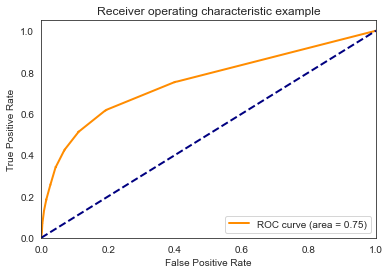

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)

preds = clf.predict_proba(X_test)
predictions = preds[:,1].reshape(-1,1)
results = pd.DataFrame(data = np.hstack((y_test.values.reshape(-1,1), predictions)), columns = ['label', 'pred_proba'])

plotAUC(results.label, results.pred_proba)

# Trying Catboost

In [17]:
df = pd.read_feather('00_data/data_target_cleaned.ftr')
y = df.pop('y')
# taking a stratified sample for train test split. 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=42, stratify = y)


In [18]:
cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=catCols)

In [19]:
def objective(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),#, "CrossEntropy"]),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 8),
        "one_hot_max_size": trial.suggest_int('one_hot_max_size', 4,12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian"],#, "Bernoulli", "MVS"]
        ),
        "task_type": "GPU",
        "eval_metric": "AUC", 
        "used_ram_limit": "48gb",
        "iterations": 250,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#     gbm = CatBoostClassifier(**param)
    scores = cv(cv_dataset,
            param,
            fold_count=2,
            type = 'Classical',
            early_stopping_rounds = 100,
            plot="False")
       
    # Returns the last iteration for the optimizer to take into account
    return scores['test-AUC-mean'].iloc[-1]

In [39]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2021-08-10 11:36:37,131] A new study created in memory with name: no-name-1c66829e-f23f-40dd-8dda-285c89704fd3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5996045	best: 0.5996045 (0)	total: 1.66s	remaining: 6m 52s
1:	test: 0.5996045	best: 0.5996045 (0)	total: 3.08s	remaining: 6m 22s
2:	test: 0.5996045	best: 0.5996045 (0)
3:	test: 0.6041287	best: 0.6041287 (3)	total: 4.66s	remaining: 4m 46s
4:	test: 0.6041287	best: 0.6041287 (3)	total: 6.11s	remaining: 4m 59s
5:	test: 0.6049189	best: 0.6049189 (5)	total: 7.54s	remaining: 5m 6s
6:	test: 0.6049189	best: 0.6049189 (5)	total: 9.02s	remaining: 5m 13s
7:	test: 0.6049189	best: 0.6049189 (5)	total: 10.5s	remaining: 5m 16s
8:	test: 0.6049189	best: 0.6049189 (5)
9:	test: 0.6052288	best: 0.6052288 (9)	total: 12.1s	remaining: 4m 49s
10:	test: 0.6052288	best: 0.6052288 (9)
11:	test: 0.6052288	best: 0.6052288 (9)	total: 13.7s	remaining: 4m 31s
12:	test: 0.6052288	best: 0.6052288 (9)
13:	test: 0.6052288	best: 0.6052288 (9)	total: 15.3s	remaining: 4m 17s
14:	test: 0.6052288	best: 0.6052288 (9)
15:	test: 0.6052288	best: 0.6052288 (9)	total: 16.8s	remaining: 4m 6s
16:	test: 0.6052288	best: 0.605

132:	test: 0.7692476	best: 0.7692476 (132)
133:	test: 0.7701756	best: 0.7701756 (133)	total: 2m 17s	remaining: 1m 59s
134:	test: 0.7702055	best: 0.7702055 (134)	total: 2m 19s	remaining: 1m 58s
135:	test: 0.7701955	best: 0.7702055 (134)	total: 2m 20s	remaining: 1m 57s
136:	test: 0.7708727	best: 0.7708727 (136)	total: 2m 21s	remaining: 1m 57s
137:	test: 0.7709893	best: 0.7709893 (137)
138:	test: 0.7720875	best: 0.7720875 (138)	total: 2m 23s	remaining: 1m 54s
139:	test: 0.7721062	best: 0.7721062 (139)
140:	test: 0.7723307	best: 0.7723307 (140)	total: 2m 25s	remaining: 1m 52s
141:	test: 0.7724405	best: 0.7724405 (141)
142:	test: 0.7726294	best: 0.7726294 (142)	total: 2m 26s	remaining: 1m 49s
143:	test: 0.7727866	best: 0.7727866 (143)	total: 2m 28s	remaining: 1m 49s
144:	test: 0.7728223	best: 0.7728223 (144)
145:	test: 0.7731338	best: 0.7731338 (145)	total: 2m 30s	remaining: 1m 46s
146:	test: 0.7731510	best: 0.7731510 (146)	total: 2m 31s	remaining: 1m 46s
147:	test: 0.7741488	best: 0.774148

[I 2021-08-10 11:41:05,505] Trial 0 finished with value: 0.7835200130939484 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.28072147612684284}. Best is trial 0 with value: 0.7835200130939484.


249:	test: 0.7835200	best: 0.7835200 (249)	total: 4m 28s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5998873	best: 0.5998873 (0)
1:	test: 0.6006751	best: 0.6006751 (1)
2:	test: 0.6046464	best: 0.6046464 (2)	total: 1.46s	remaining: 2m
3:	test: 0.6044623	best: 0.6046464 (2)
4:	test: 0.6039270	best: 0.6046464 (2)
5:	test: 0.6034592	best: 0.6046464 (2)	total: 2.97s	remaining: 2m
6:	test: 0.6033631	best: 0.6046464 (2)
7:	test: 0.6033631	best: 0.6046464 (2)
8:	test: 0.6033551	best: 0.6046464 (2)	total: 4.71s	remaining: 2m 6s
9:	test: 0.6031526	best: 0.6046464 (2)
10:	test: 0.6031526	best: 0.6046464 (2)
11:	test: 0.6031526	best: 0.6046464 (2)
12:	test: 0.6029236	best: 0.6046464 (2)	total: 6.2s	remaining: 1m 53s
13:	test: 0.6032690	best: 0.6046464 (2)
14:	test: 0.6037686	best: 0.6046464 (2)
15:	test: 0.6037686	best: 0.6046464 (2)	total: 7.63s	remaining: 1m 51s
16:	test: 0.6037686	best: 0.6046464 (2)
17:	test: 0.6049846	best: 0.6049846 (17)
18:	test: 0.6037686	best: 0.6049846 (17)	total: 9.03s	remaining: 1m 49s
19:	test: 0.6050316	best: 0.6050316 (19)
20:	test: 0.6050316	best: 0.605

153:	test: 0.7671878	best: 0.7671878 (153)
154:	test: 0.7671931	best: 0.7671931 (154)	total: 1m 31s	remaining: 56.4s
155:	test: 0.7672508	best: 0.7672508 (155)	total: 1m 33s	remaining: 56.4s
156:	test: 0.7677117	best: 0.7677117 (156)	total: 1m 35s	remaining: 56.3s
157:	test: 0.7678078	best: 0.7678078 (157)	total: 1m 36s	remaining: 56.2s
158:	test: 0.7678152	best: 0.7678152 (158)
159:	test: 0.7678186	best: 0.7678186 (159)	total: 1m 38s	remaining: 55.2s
160:	test: 0.7679076	best: 0.7679076 (160)	total: 1m 39s	remaining: 55s
161:	test: 0.7688808	best: 0.7688808 (161)	total: 1m 41s	remaining: 54.9s
162:	test: 0.7689889	best: 0.7689889 (162)
163:	test: 0.7691185	best: 0.7691185 (163)	total: 1m 42s	remaining: 53.8s
164:	test: 0.7692575	best: 0.7692575 (164)
165:	test: 0.7692604	best: 0.7692604 (165)	total: 1m 44s	remaining: 52.7s
166:	test: 0.7693531	best: 0.7693531 (166)
167:	test: 0.7693607	best: 0.7693607 (167)	total: 1m 45s	remaining: 51.6s
168:	test: 0.7693682	best: 0.7693682 (168)	tota

[I 2021-08-10 11:44:06,506] Trial 1 finished with value: 0.7742127776145935 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.2955745445517035}. Best is trial 0 with value: 0.7835200130939484.


249:	test: 0.7742128	best: 0.7742174 (248)	total: 3m	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5959214	best: 0.5959214 (0)
1:	test: 0.6008851	best: 0.6008851 (1)	total: 1.62s	remaining: 3m 21s
2:	test: 0.6008851	best: 0.6008851 (1)
3:	test: 0.6008851	best: 0.6008851 (1)	total: 4.03s	remaining: 4m 7s
4:	test: 0.5995191	best: 0.6008851 (1)	total: 5.87s	remaining: 4m 47s
5:	test: 0.5995191	best: 0.6008851 (1)	total: 7.46s	remaining: 5m 3s
6:	test: 0.5995191	best: 0.6008851 (1)	total: 9.01s	remaining: 5m 12s
7:	test: 0.5995191	best: 0.6008851 (1)	total: 10.9s	remaining: 5m 28s
8:	test: 0.5995191	best: 0.6008851 (1)	total: 12.5s	remaining: 5m 35s
9:	test: 0.5993603	best: 0.6008851 (1)	total: 14.5s	remaining: 5m 47s
10:	test: 0.5993603	best: 0.6008851 (1)	total: 16s	remaining: 5m 47s
11:	test: 0.5993603	best: 0.6008851 (1)	total: 18.1s	remaining: 5m 58s
12:	test: 0.5993603	best: 0.6008851 (1)	total: 19.8s	remaining: 6m 1s
13:	test: 0.5993603	best: 0.6008851 (1)	total: 21.5s	remaining: 6m 2s
14:	test: 0.5993603	best: 0.6008851 (1)	total: 23.3s	remaining: 6m 5s
15:	test: 0.59

115:	test: 0.7445477	best: 0.7446652 (112)	total: 3m 13s	remaining: 3m 43s
116:	test: 0.7444137	best: 0.7446652 (112)	total: 3m 14s	remaining: 3m 41s
117:	test: 0.7444302	best: 0.7446652 (112)	total: 3m 16s	remaining: 3m 39s
118:	test: 0.7444173	best: 0.7446652 (112)	total: 3m 17s	remaining: 3m 37s
119:	test: 0.7443812	best: 0.7446652 (112)	total: 3m 19s	remaining: 3m 35s
120:	test: 0.7443705	best: 0.7446652 (112)	total: 3m 20s	remaining: 3m 34s
121:	test: 0.7443678	best: 0.7446652 (112)	total: 3m 22s	remaining: 3m 32s
122:	test: 0.7448201	best: 0.7448201 (122)
123:	test: 0.7461557	best: 0.7461557 (123)	total: 3m 24s	remaining: 3m 27s
124:	test: 0.7460660	best: 0.7461557 (123)	total: 3m 25s	remaining: 3m 25s
125:	test: 0.7460059	best: 0.7461557 (123)	total: 3m 27s	remaining: 3m 23s
126:	test: 0.7459585	best: 0.7461557 (123)	total: 3m 28s	remaining: 3m 22s
127:	test: 0.7458594	best: 0.7461557 (123)	total: 3m 30s	remaining: 3m 20s
128:	test: 0.7458289	best: 0.7461557 (123)	total: 3m 31s	

227:	test: 0.7495360	best: 0.7495360 (227)	total: 5m 58s	remaining: 34.6s
228:	test: 0.7497976	best: 0.7497976 (228)	total: 6m	remaining: 33s
229:	test: 0.7497861	best: 0.7497976 (228)	total: 6m 1s	remaining: 31.4s
230:	test: 0.7498143	best: 0.7498143 (230)	total: 6m 3s	remaining: 29.9s
231:	test: 0.7498368	best: 0.7498368 (231)	total: 6m 4s	remaining: 28.3s
232:	test: 0.7498400	best: 0.7498400 (232)	total: 6m 6s	remaining: 26.7s
233:	test: 0.7498904	best: 0.7498904 (233)	total: 6m 7s	remaining: 25.1s
234:	test: 0.7498884	best: 0.7498904 (233)	total: 6m 9s	remaining: 23.6s
235:	test: 0.7498851	best: 0.7498904 (233)	total: 6m 10s	remaining: 22s
236:	test: 0.7499101	best: 0.7499101 (236)	total: 6m 11s	remaining: 20.4s
237:	test: 0.7499229	best: 0.7499229 (237)	total: 6m 13s	remaining: 18.8s
238:	test: 0.7499847	best: 0.7499847 (238)	total: 6m 14s	remaining: 17.3s
239:	test: 0.7499851	best: 0.7499851 (239)	total: 6m 16s	remaining: 15.7s
240:	test: 0.7500100	best: 0.7500100 (240)	total: 6m

[I 2021-08-10 11:50:38,632] Trial 2 finished with value: 0.7499962896108627 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.850219467386114}. Best is trial 0 with value: 0.7835200130939484.


249:	test: 0.7499963	best: 0.7500100 (240)	total: 6m 31s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5959214	best: 0.5959214 (0)
1:	test: 0.6028803	best: 0.6028803 (1)
2:	test: 0.6038831	best: 0.6038831 (2)	total: 1.84s	remaining: 2m 31s
3:	test: 0.6046800	best: 0.6046800 (3)
4:	test: 0.6048351	best: 0.6048351 (4)	total: 3.46s	remaining: 2m 49s
5:	test: 0.6051094	best: 0.6051094 (5)	total: 4.92s	remaining: 3m 20s
6:	test: 0.6051094	best: 0.6051094 (5)
7:	test: 0.6058571	best: 0.6058571 (7)	total: 6.56s	remaining: 3m 18s
8:	test: 0.6058571	best: 0.6058571 (7)
9:	test: 0.6042555	best: 0.6058571 (7)	total: 8.21s	remaining: 3m 16s
10:	test: 0.6042555	best: 0.6058571 (7)	total: 9.74s	remaining: 3m 31s
11:	test: 0.6042555	best: 0.6058571 (7)
12:	test: 0.6042513	best: 0.6058571 (7)	total: 11.4s	remaining: 3m 27s
13:	test: 0.6042513	best: 0.6058571 (7)	total: 12.9s	remaining: 3m 37s
14:	test: 0.6042513	best: 0.6058571 (7)	total: 14.3s	remaining: 3m 44s
15:	test: 0.6042513	best: 0.6058571 (7)	total: 15.8s	remaining: 3m 51s
16:	test: 0.6042513	best: 0.6058571 (7)
17:	test: 0.6042513	

118:	test: 0.7495961	best: 0.7497484 (117)	total: 2m 50s	remaining: 3m 7s
119:	test: 0.7495192	best: 0.7497484 (117)	total: 2m 51s	remaining: 3m 6s
120:	test: 0.7495077	best: 0.7497484 (117)	total: 2m 53s	remaining: 3m 4s
121:	test: 0.7495312	best: 0.7497484 (117)	total: 2m 54s	remaining: 3m 3s
122:	test: 0.7493910	best: 0.7497484 (117)	total: 2m 56s	remaining: 3m 2s
123:	test: 0.7493238	best: 0.7497484 (117)	total: 2m 57s	remaining: 3m
124:	test: 0.7493265	best: 0.7497484 (117)	total: 2m 59s	remaining: 2m 59s
125:	test: 0.7493814	best: 0.7497484 (117)	total: 3m	remaining: 2m 58s
126:	test: 0.7493688	best: 0.7497484 (117)	total: 3m 2s	remaining: 2m 56s
127:	test: 0.7493658	best: 0.7497484 (117)	total: 3m 3s	remaining: 2m 55s
128:	test: 0.7492995	best: 0.7497484 (117)	total: 3m 5s	remaining: 2m 53s
129:	test: 0.7492720	best: 0.7497484 (117)	total: 3m 6s	remaining: 2m 52s
130:	test: 0.7492915	best: 0.7497484 (117)	total: 3m 8s	remaining: 2m 51s
131:	test: 0.7492394	best: 0.7497484 (117)	

229:	test: 0.7501028	best: 0.7505771 (176)	total: 5m 36s	remaining: 29.3s
230:	test: 0.7501130	best: 0.7505771 (176)	total: 5m 38s	remaining: 27.8s
231:	test: 0.7501104	best: 0.7505771 (176)	total: 5m 39s	remaining: 26.3s
232:	test: 0.7501161	best: 0.7505771 (176)	total: 5m 41s	remaining: 24.9s
233:	test: 0.7501171	best: 0.7505771 (176)	total: 5m 42s	remaining: 23.4s
234:	test: 0.7500919	best: 0.7505771 (176)	total: 5m 43s	remaining: 22s
235:	test: 0.7500909	best: 0.7505771 (176)	total: 5m 45s	remaining: 20.5s
236:	test: 0.7500837	best: 0.7505771 (176)	total: 5m 46s	remaining: 19s
237:	test: 0.7500843	best: 0.7505771 (176)	total: 5m 48s	remaining: 17.6s
238:	test: 0.7500822	best: 0.7505771 (176)	total: 5m 49s	remaining: 16.1s
239:	test: 0.7500816	best: 0.7505771 (176)	total: 5m 51s	remaining: 14.6s
240:	test: 0.7500755	best: 0.7505771 (176)	total: 5m 52s	remaining: 13.2s
241:	test: 0.7500596	best: 0.7505771 (176)	total: 5m 54s	remaining: 11.7s
242:	test: 0.7500697	best: 0.7505771 (176)

[I 2021-08-10 11:56:44,107] Trial 3 finished with value: 0.7500237375497818 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.760942937517241}. Best is trial 0 with value: 0.7835200130939484.


249:	test: 0.7500237	best: 0.7505771 (176)	total: 6m 5s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5941239	best: 0.5941239 (0)
1:	test: 0.5921692	best: 0.5941239 (0)
2:	test: 0.5929004	best: 0.5941239 (0)	total: 1.45s	remaining: 1m 59s
3:	test: 0.5938747	best: 0.5941239 (0)
4:	test: 0.5929964	best: 0.5941239 (0)
5:	test: 0.5971535	best: 0.5971535 (5)	total: 2.9s	remaining: 1m 58s
6:	test: 0.5980318	best: 0.5980318 (6)
7:	test: 0.5971535	best: 0.5980318 (6)
8:	test: 0.5980318	best: 0.5980318 (6)	total: 4.35s	remaining: 1m 56s
9:	test: 0.5980318	best: 0.5980318 (6)
10:	test: 0.5971535	best: 0.5980318 (6)
11:	test: 0.5980318	best: 0.5980318 (6)	total: 5.77s	remaining: 1m 54s
12:	test: 0.6017613	best: 0.6017613 (12)
13:	test: 0.6017613	best: 0.6017613 (12)
14:	test: 0.6016652	best: 0.6017613 (12)	total: 7.19s	remaining: 1m 52s
15:	test: 0.6016652	best: 0.6017613 (12)
16:	test: 0.6016652	best: 0.6017613 (12)
17:	test: 0.6016652	best: 0.6017613 (12)	total: 8.65s	remaining: 1m 51s
18:	test: 0.6015463	best: 0.6017613 (12)
19:	test: 0.6015463	best: 0.6017613 (12)
20:	test: 0.60154

148:	test: 0.7537080	best: 0.7537080 (148)
149:	test: 0.7544285	best: 0.7544285 (149)	total: 1m 36s	remaining: 1m 4s
150:	test: 0.7544366	best: 0.7544366 (150)
151:	test: 0.7545041	best: 0.7545041 (151)	total: 1m 38s	remaining: 1m 3s
152:	test: 0.7545013	best: 0.7545041 (151)
153:	test: 0.7546012	best: 0.7546012 (153)	total: 1m 39s	remaining: 1m 2s
154:	test: 0.7547739	best: 0.7547739 (154)
155:	test: 0.7547712	best: 0.7547739 (154)	total: 1m 40s	remaining: 1m
156:	test: 0.7547687	best: 0.7547739 (154)
157:	test: 0.7564901	best: 0.7564901 (157)	total: 1m 42s	remaining: 59.6s
158:	test: 0.7575116	best: 0.7575116 (158)
159:	test: 0.7572779	best: 0.7575116 (158)	total: 1m 43s	remaining: 58.4s
160:	test: 0.7572456	best: 0.7575116 (158)
161:	test: 0.7572618	best: 0.7575116 (158)	total: 1m 45s	remaining: 57.2s
162:	test: 0.7575717	best: 0.7575717 (162)
163:	test: 0.7575486	best: 0.7575717 (162)	total: 1m 46s	remaining: 56s
164:	test: 0.7575522	best: 0.7575717 (162)
165:	test: 0.7581566	best:

[I 2021-08-10 11:59:34,781] Trial 4 finished with value: 0.7603330165147781 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.772088655039192}. Best is trial 0 with value: 0.7835200130939484.


248:	test: 0.7603519	best: 0.7603596 (247)
249:	test: 0.7603330	best: 0.7603596 (247)	total: 2m 50s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634037	best: 0.7634037 (0)
1:	test: 0.7688077	best: 0.7688077 (1)
2:	test: 0.7829553	best: 0.7829553 (2)
3:	test: 0.7832219	best: 0.7832219 (3)
4:	test: 0.7834195	best: 0.7834195 (4)
5:	test: 0.7837524	best: 0.7837524 (5)
6:	test: 0.7845286	best: 0.7845286 (6)	total: 1.52s	remaining: 52.7s
7:	test: 0.7846044	best: 0.7846044 (7)
8:	test: 0.7852482	best: 0.7852482 (8)
9:	test: 0.7878816	best: 0.7878816 (9)
10:	test: 0.7883690	best: 0.7883690 (10)
11:	test: 0.7885416	best: 0.7885416 (11)
12:	test: 0.7883275	best: 0.7885416 (11)	total: 3.1s	remaining: 56.5s
13:	test: 0.7881064	best: 0.7885416 (11)
14:	test: 0.7878544	best: 0.7885416 (11)
15:	test: 0.7886279	best: 0.7886279 (15)
16:	test: 0.7887721	best: 0.7887721 (16)
17:	test: 0.7885936	best: 0.7887721 (16)
18:	test: 0.7882302	best: 0.7887721 (16)
19:	test: 0.7885605	best: 0.7887721 (16)	total: 4.63s	remaining: 53.3s
20:	test: 0.7887771	best: 0.7887771 (20)
21:	test: 0.7883238	best: 0.7887771 (20)
22:	test: 0.7894317	best: 0.7

177:	test: 0.7943775	best: 0.7943989 (176)
178:	test: 0.7944211	best: 0.7944211 (178)
179:	test: 0.7944838	best: 0.7944838 (179)
180:	test: 0.7944845	best: 0.7944845 (180)
181:	test: 0.7944768	best: 0.7944845 (180)
182:	test: 0.7945155	best: 0.7945155 (182)	total: 46.3s	remaining: 16.9s
183:	test: 0.7945427	best: 0.7945427 (183)
184:	test: 0.7945508	best: 0.7945508 (184)
185:	test: 0.7945175	best: 0.7945508 (184)
186:	test: 0.7945129	best: 0.7945508 (184)
187:	test: 0.7945195	best: 0.7945508 (184)
188:	test: 0.7945716	best: 0.7945716 (188)	total: 47.8s	remaining: 15.4s
189:	test: 0.7945426	best: 0.7945716 (188)
190:	test: 0.7945649	best: 0.7945716 (188)
191:	test: 0.7945144	best: 0.7945716 (188)
192:	test: 0.7944943	best: 0.7945716 (188)
193:	test: 0.7945294	best: 0.7945716 (188)
194:	test: 0.7945216	best: 0.7945716 (188)	total: 49.2s	remaining: 13.9s
195:	test: 0.7945647	best: 0.7945716 (188)
196:	test: 0.7945662	best: 0.7945716 (188)
197:	test: 0.7945959	best: 0.7945959 (197)
198:	te

[I 2021-08-10 12:00:37,704] Trial 5 finished with value: 0.7955171912908554 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07561332056188697}. Best is trial 5 with value: 0.7955171912908554.


244:	test: 0.7954443	best: 0.7954457 (242)
245:	test: 0.7954100	best: 0.7954457 (242)
246:	test: 0.7954204	best: 0.7954457 (242)
247:	test: 0.7954013	best: 0.7954457 (242)
248:	test: 0.7954320	best: 0.7954457 (242)
249:	test: 0.7955172	best: 0.7955172 (249)	total: 1m 2s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5981610	best: 0.5981610 (0)
1:	test: 0.6005704	best: 0.6005704 (1)	total: 1.5s	remaining: 3m 5s
2:	test: 0.5998880	best: 0.6005704 (1)	total: 2.88s	remaining: 3m 57s
3:	test: 0.5999073	best: 0.6005704 (1)	total: 4.28s	remaining: 4m 23s
4:	test: 0.5999073	best: 0.6005704 (1)	total: 5.62s	remaining: 4m 35s
5:	test: 0.5999073	best: 0.6005704 (1)	total: 7.02s	remaining: 4m 45s
6:	test: 0.5999073	best: 0.6005704 (1)	total: 8.41s	remaining: 4m 52s
7:	test: 0.5999073	best: 0.6005704 (1)	total: 9.78s	remaining: 4m 55s
8:	test: 0.5999073	best: 0.6005704 (1)
9:	test: 0.6007788	best: 0.6007788 (9)	total: 11.3s	remaining: 4m 30s
10:	test: 0.6011245	best: 0.6011245 (10)
11:	test: 0.6011245	best: 0.6011245 (10)	total: 12.8s	remaining: 4m 14s
12:	test: 0.6011245	best: 0.6011245 (10)
13:	test: 0.6011245	best: 0.6011245 (10)	total: 14.4s	remaining: 4m 2s
14:	test: 0.6011245	best: 0.6011245 (10)
15:	test: 0.6011811	best: 0.6011811 (15)	total: 15.9s	remaining: 3m 53s
16:	test: 0.6011811	best: 

119:	test: 0.7627520	best: 0.7627520 (119)	total: 2m 31s	remaining: 2m 44s
120:	test: 0.7628113	best: 0.7628113 (120)	total: 2m 32s	remaining: 2m 42s
121:	test: 0.7628368	best: 0.7628368 (121)	total: 2m 34s	remaining: 2m 41s
122:	test: 0.7628419	best: 0.7628419 (122)	total: 2m 35s	remaining: 2m 40s
123:	test: 0.7628700	best: 0.7628700 (123)	total: 2m 37s	remaining: 2m 39s
124:	test: 0.7629313	best: 0.7629313 (124)	total: 2m 38s	remaining: 2m 38s
125:	test: 0.7630911	best: 0.7630911 (125)	total: 2m 39s	remaining: 2m 37s
126:	test: 0.7630687	best: 0.7630911 (125)
127:	test: 0.7632553	best: 0.7632553 (127)	total: 2m 41s	remaining: 2m 33s
128:	test: 0.7632993	best: 0.7632993 (128)	total: 2m 42s	remaining: 2m 32s
129:	test: 0.7637709	best: 0.7637709 (129)
130:	test: 0.7641164	best: 0.7641164 (130)	total: 2m 44s	remaining: 2m 29s
131:	test: 0.7641001	best: 0.7641164 (130)	total: 2m 45s	remaining: 2m 28s
132:	test: 0.7641265	best: 0.7641265 (132)	total: 2m 47s	remaining: 2m 27s
133:	test: 0.7

235:	test: 0.7714359	best: 0.7714359 (235)	total: 5m 1s	remaining: 17.9s
236:	test: 0.7714319	best: 0.7714359 (235)	total: 5m 2s	remaining: 16.6s
237:	test: 0.7715227	best: 0.7715227 (237)	total: 5m 4s	remaining: 15.3s
238:	test: 0.7715174	best: 0.7715227 (237)	total: 5m 5s	remaining: 14.1s
239:	test: 0.7715415	best: 0.7715415 (239)	total: 5m 7s	remaining: 12.8s
240:	test: 0.7715545	best: 0.7715545 (240)	total: 5m 8s	remaining: 11.5s
241:	test: 0.7715433	best: 0.7715545 (240)
242:	test: 0.7715657	best: 0.7715657 (242)	total: 5m 10s	remaining: 8.93s
243:	test: 0.7716282	best: 0.7716282 (243)	total: 5m 11s	remaining: 7.66s
244:	test: 0.7716794	best: 0.7716794 (244)	total: 5m 13s	remaining: 6.39s
245:	test: 0.7716968	best: 0.7716968 (245)	total: 5m 14s	remaining: 5.11s
246:	test: 0.7717869	best: 0.7717869 (246)	total: 5m 16s	remaining: 3.84s
247:	test: 0.7718674	best: 0.7718674 (247)	total: 5m 17s	remaining: 2.56s
248:	test: 0.7718855	best: 0.7718855 (248)	total: 5m 18s	remaining: 1.28s


[I 2021-08-10 12:05:58,172] Trial 6 finished with value: 0.7719863057136536 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.369103073285031}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7719863	best: 0.7719863 (249)	total: 5m 20s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6030126	best: 0.6030126 (0)	total: 1.42s	remaining: 5m 54s
1:	test: 0.6030126	best: 0.6030126 (0)
2:	test: 0.6053546	best: 0.6053546 (2)	total: 2.96s	remaining: 4m 3s
3:	test: 0.6053546	best: 0.6053546 (2)	total: 4.37s	remaining: 4m 28s
4:	test: 0.6053642	best: 0.6053642 (4)	total: 5.78s	remaining: 4m 43s
5:	test: 0.6053642	best: 0.6053642 (4)	total: 7.2s	remaining: 4m 52s
6:	test: 0.6051786	best: 0.6053642 (4)	total: 8.62s	remaining: 4m 59s
7:	test: 0.6053642	best: 0.6053642 (4)
8:	test: 0.6056741	best: 0.6056741 (8)	total: 10.1s	remaining: 4m 31s
9:	test: 0.6056741	best: 0.6056741 (8)	total: 11.6s	remaining: 4m 37s
10:	test: 0.6056741	best: 0.6056741 (8)	total: 13s	remaining: 4m 42s
11:	test: 0.6039273	best: 0.6056741 (8)
12:	test: 0.6039273	best: 0.6056741 (8)	total: 14.7s	remaining: 4m 27s
13:	test: 0.6033935	best: 0.6056741 (8)
14:	test: 0.6033935	best: 0.6056741 (8)	total: 16.2s	remaining: 4m 14s
15:	test: 0.6033935	best: 0.6056741 (8)
16:	test: 0.6034069	best: 0.60567

122:	test: 0.7659530	best: 0.7659530 (122)	total: 2m 32s	remaining: 2m 37s
123:	test: 0.7659402	best: 0.7659530 (122)	total: 2m 33s	remaining: 2m 36s
124:	test: 0.7660099	best: 0.7660099 (124)
125:	test: 0.7660444	best: 0.7660444 (125)	total: 2m 35s	remaining: 2m 32s
126:	test: 0.7660284	best: 0.7660444 (125)	total: 2m 36s	remaining: 2m 31s
127:	test: 0.7660270	best: 0.7660444 (125)	total: 2m 37s	remaining: 2m 30s
128:	test: 0.7660381	best: 0.7660444 (125)	total: 2m 39s	remaining: 2m 29s
129:	test: 0.7660315	best: 0.7660444 (125)
130:	test: 0.7660426	best: 0.7660444 (125)	total: 2m 40s	remaining: 2m 26s
131:	test: 0.7661382	best: 0.7661382 (131)	total: 2m 42s	remaining: 2m 25s
132:	test: 0.7661316	best: 0.7661382 (131)	total: 2m 43s	remaining: 2m 24s
133:	test: 0.7661646	best: 0.7661646 (133)	total: 2m 45s	remaining: 2m 23s
134:	test: 0.7662600	best: 0.7662600 (134)	total: 2m 46s	remaining: 2m 22s
135:	test: 0.7662925	best: 0.7662925 (135)
136:	test: 0.7663342	best: 0.7663342 (136)	tot

240:	test: 0.7767938	best: 0.7767938 (240)	total: 4m 59s	remaining: 11.2s
241:	test: 0.7767964	best: 0.7767964 (241)	total: 5m	remaining: 9.94s
242:	test: 0.7767701	best: 0.7767964 (241)	total: 5m 2s	remaining: 8.7s
243:	test: 0.7767987	best: 0.7767987 (243)	total: 5m 3s	remaining: 7.46s
244:	test: 0.7768022	best: 0.7768022 (244)	total: 5m 5s	remaining: 6.23s
245:	test: 0.7768905	best: 0.7768905 (245)	total: 5m 6s	remaining: 4.99s
246:	test: 0.7769317	best: 0.7769317 (246)	total: 5m 8s	remaining: 3.74s
247:	test: 0.7769381	best: 0.7769381 (247)	total: 5m 9s	remaining: 2.5s
248:	test: 0.7769395	best: 0.7769395 (248)	total: 5m 11s	remaining: 1.25s


[I 2021-08-10 12:11:10,929] Trial 7 finished with value: 0.7769912630319595 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.034484096751582}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7769913	best: 0.7769913 (249)	total: 5m 12s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5750215	best: 0.5750215 (0)
1:	test: 0.5928473	best: 0.5928473 (1)	total: 1.55s	remaining: 3m 11s
2:	test: 0.5928473	best: 0.5928473 (1)
3:	test: 0.5948698	best: 0.5948698 (3)	total: 3.25s	remaining: 3m 19s
4:	test: 0.5948698	best: 0.5948698 (3)
5:	test: 0.5957091	best: 0.5957091 (5)	total: 4.84s	remaining: 3m 16s
6:	test: 0.5954623	best: 0.5957091 (5)
7:	test: 0.5954623	best: 0.5957091 (5)	total: 6.41s	remaining: 3m 13s
8:	test: 0.5954623	best: 0.5957091 (5)
9:	test: 0.5973775	best: 0.5973775 (9)	total: 8s	remaining: 3m 11s
10:	test: 0.5973775	best: 0.5973775 (9)
11:	test: 0.5973775	best: 0.5973775 (9)	total: 9.56s	remaining: 3m 9s
12:	test: 0.5973775	best: 0.5973775 (9)
13:	test: 0.5973775	best: 0.5973775 (9)	total: 11.1s	remaining: 3m 7s
14:	test: 0.5973775	best: 0.5973775 (9)
15:	test: 0.5973775	best: 0.5973775 (9)	total: 12.7s	remaining: 3m 5s
16:	test: 0.5974160	best: 0.5974160 (16)
17:	test: 0.5974160	best: 0.5974160 (16)	total: 14.2s	remaining: 3m 3s
18:	test: 0.5974

121:	test: 0.7444803	best: 0.7454065 (103)	total: 2m 34s	remaining: 2m 42s
122:	test: 0.7444145	best: 0.7454065 (103)	total: 2m 36s	remaining: 2m 41s
123:	test: 0.7444794	best: 0.7454065 (103)	total: 2m 37s	remaining: 2m 40s
124:	test: 0.7444463	best: 0.7454065 (103)	total: 2m 39s	remaining: 2m 39s
125:	test: 0.7443821	best: 0.7454065 (103)
126:	test: 0.7443645	best: 0.7454065 (103)	total: 2m 40s	remaining: 2m 35s
127:	test: 0.7445653	best: 0.7454065 (103)
128:	test: 0.7445897	best: 0.7454065 (103)	total: 2m 42s	remaining: 2m 32s
129:	test: 0.7445560	best: 0.7454065 (103)	total: 2m 43s	remaining: 2m 31s
130:	test: 0.7445471	best: 0.7454065 (103)
131:	test: 0.7445651	best: 0.7454065 (103)	total: 2m 45s	remaining: 2m 27s
132:	test: 0.7445260	best: 0.7454065 (103)	total: 2m 46s	remaining: 2m 26s
133:	test: 0.7444806	best: 0.7454065 (103)
134:	test: 0.7444728	best: 0.7454065 (103)	total: 2m 48s	remaining: 2m 23s
135:	test: 0.7444461	best: 0.7454065 (103)	total: 2m 49s	remaining: 2m 22s
136

245:	test: 0.7497289	best: 0.7497289 (245)
246:	test: 0.7496819	best: 0.7497289 (245)	total: 4m 57s	remaining: 3.61s
247:	test: 0.7497338	best: 0.7497338 (247)	total: 4m 58s	remaining: 2.41s
248:	test: 0.7495471	best: 0.7497338 (247)	total: 5m	remaining: 1.21s


[I 2021-08-10 12:16:12,523] Trial 8 finished with value: 0.7495160549879074 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.277406198461012}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7495161	best: 0.7497338 (247)	total: 5m 1s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6050070	best: 0.6050070 (0)
1:	test: 0.6049426	best: 0.6050070 (0)
2:	test: 0.6060141	best: 0.6060141 (2)	total: 1.52s	remaining: 2m 5s
3:	test: 0.6058116	best: 0.6060141 (2)
4:	test: 0.6045318	best: 0.6060141 (2)	total: 2.98s	remaining: 2m 26s
5:	test: 0.6045318	best: 0.6060141 (2)
6:	test: 0.6045934	best: 0.6060141 (2)
7:	test: 0.6060310	best: 0.6060310 (7)	total: 4.5s	remaining: 2m 16s
8:	test: 0.6060310	best: 0.6060310 (7)
9:	test: 0.6060310	best: 0.6060310 (7)	total: 5.94s	remaining: 2m 22s
10:	test: 0.6060310	best: 0.6060310 (7)
11:	test: 0.6059851	best: 0.6060310 (7)	total: 7.41s	remaining: 2m 26s
12:	test: 0.6059851	best: 0.6060310 (7)
13:	test: 0.6059851	best: 0.6060310 (7)
14:	test: 0.6059851	best: 0.6060310 (7)	total: 8.96s	remaining: 2m 20s
15:	test: 0.6059851	best: 0.6060310 (7)
16:	test: 0.6059851	best: 0.6060310 (7)	total: 10.4s	remaining: 2m 22s
17:	test: 0.6059851	best: 0.6060310 (7)
18:	test: 0.6060310	best: 0.6060310 (7)
19:	test: 0.6061753	best: 0.6061753

147:	test: 0.7688005	best: 0.7688005 (147)
148:	test: 0.7688364	best: 0.7688364 (148)	total: 1m 46s	remaining: 1m 12s
149:	test: 0.7689971	best: 0.7689971 (149)
150:	test: 0.7695032	best: 0.7695032 (150)	total: 1m 48s	remaining: 1m 10s
151:	test: 0.7695124	best: 0.7695124 (151)
152:	test: 0.7694907	best: 0.7695124 (151)	total: 1m 49s	remaining: 1m 9s
153:	test: 0.7695427	best: 0.7695427 (153)
154:	test: 0.7699447	best: 0.7699447 (154)	total: 1m 51s	remaining: 1m 8s
155:	test: 0.7699247	best: 0.7699447 (154)
156:	test: 0.7699528	best: 0.7699528 (156)	total: 1m 52s	remaining: 1m 6s
157:	test: 0.7699089	best: 0.7699528 (156)
158:	test: 0.7700639	best: 0.7700639 (158)	total: 1m 54s	remaining: 1m 5s
159:	test: 0.7700419	best: 0.7700639 (158)
160:	test: 0.7700396	best: 0.7700639 (158)	total: 1m 55s	remaining: 1m 3s
161:	test: 0.7700433	best: 0.7700639 (158)
162:	test: 0.7702280	best: 0.7702280 (162)	total: 1m 57s	remaining: 1m 2s
163:	test: 0.7703314	best: 0.7703314 (163)	total: 1m 58s	remai

[I 2021-08-10 12:19:25,808] Trial 9 finished with value: 0.7726199924945831 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3669650059715064}. Best is trial 5 with value: 0.7955171912908554.


248:	test: 0.7726137	best: 0.7726724 (247)
249:	test: 0.7726200	best: 0.7726724 (247)	total: 3m 13s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634037	best: 0.7634037 (0)
1:	test: 0.7688077	best: 0.7688077 (1)
2:	test: 0.7829553	best: 0.7829553 (2)
3:	test: 0.7832219	best: 0.7832219 (3)
4:	test: 0.7830810	best: 0.7832219 (3)
5:	test: 0.7839874	best: 0.7839874 (5)	total: 1.49s	remaining: 1m
6:	test: 0.7839542	best: 0.7839874 (5)
7:	test: 0.7850460	best: 0.7850460 (7)
8:	test: 0.7872817	best: 0.7872817 (8)
9:	test: 0.7873966	best: 0.7873966 (9)
10:	test: 0.7873733	best: 0.7873966 (9)
11:	test: 0.7875878	best: 0.7875878 (11)	total: 2.96s	remaining: 58.6s
12:	test: 0.7873524	best: 0.7875878 (11)
13:	test: 0.7869949	best: 0.7875878 (11)
14:	test: 0.7881588	best: 0.7881588 (14)
15:	test: 0.7884205	best: 0.7884205 (15)
16:	test: 0.7882161	best: 0.7884205 (15)
17:	test: 0.7878933	best: 0.7884205 (15)
18:	test: 0.7890092	best: 0.7890092 (18)	total: 4.48s	remaining: 54.5s
19:	test: 0.7887738	best: 0.7890092 (18)
20:	test: 0.7890036	best: 0.7890092 (18)
21:	test: 0.7894792	best: 0.7894792 (21)
22:	test: 0.7892051	best: 0.7894

181:	test: 0.7946915	best: 0.7948218 (172)
182:	test: 0.7946590	best: 0.7948218 (172)
183:	test: 0.7946583	best: 0.7948218 (172)
184:	test: 0.7946529	best: 0.7948218 (172)
185:	test: 0.7946789	best: 0.7948218 (172)
186:	test: 0.7947010	best: 0.7948218 (172)	total: 44.3s	remaining: 14.9s
187:	test: 0.7947032	best: 0.7948218 (172)
188:	test: 0.7947684	best: 0.7948218 (172)
189:	test: 0.7947941	best: 0.7948218 (172)
190:	test: 0.7947941	best: 0.7948218 (172)
191:	test: 0.7947928	best: 0.7948218 (172)
192:	test: 0.7948054	best: 0.7948218 (172)	total: 45.8s	remaining: 13.5s
193:	test: 0.7948003	best: 0.7948218 (172)
194:	test: 0.7948001	best: 0.7948218 (172)
195:	test: 0.7948141	best: 0.7948218 (172)
196:	test: 0.7948100	best: 0.7948218 (172)
197:	test: 0.7948802	best: 0.7948802 (197)
198:	test: 0.7948699	best: 0.7948802 (197)	total: 47.2s	remaining: 12.1s
199:	test: 0.7948577	best: 0.7948802 (197)
200:	test: 0.7948645	best: 0.7948802 (197)
201:	test: 0.7949071	best: 0.7949071 (201)
202:	te

[I 2021-08-10 12:20:28,039] Trial 10 finished with value: 0.795402005314827 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.20516193325286589}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7954020	best: 0.7954020 (249)	total: 1m 2s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634037	best: 0.7634037 (0)
1:	test: 0.7689012	best: 0.7689012 (1)
2:	test: 0.7830611	best: 0.7830611 (2)
3:	test: 0.7833596	best: 0.7833596 (3)
4:	test: 0.7835499	best: 0.7835499 (4)
5:	test: 0.7838622	best: 0.7838622 (5)
6:	test: 0.7846117	best: 0.7846117 (6)	total: 1.5s	remaining: 52.2s
7:	test: 0.7846738	best: 0.7846738 (7)
8:	test: 0.7853218	best: 0.7853218 (8)
9:	test: 0.7862621	best: 0.7862621 (9)
10:	test: 0.7870550	best: 0.7870550 (10)
11:	test: 0.7871448	best: 0.7871448 (11)
12:	test: 0.7873329	best: 0.7873329 (12)	total: 3s	remaining: 54.8s
13:	test: 0.7871040	best: 0.7873329 (12)
14:	test: 0.7873144	best: 0.7873329 (12)
15:	test: 0.7877587	best: 0.7877587 (15)
16:	test: 0.7878394	best: 0.7878394 (16)
17:	test: 0.7880677	best: 0.7880677 (17)
18:	test: 0.7876625	best: 0.7880677 (17)	total: 4.59s	remaining: 55.8s
19:	test: 0.7873360	best: 0.7880677 (17)
20:	test: 0.7873088	best: 0.7880677 (17)
21:	test: 0.7879537	best: 0.7880677 (17)
22:	test: 0.7881480	best: 0.7881

179:	test: 0.7943349	best: 0.7943373 (178)
180:	test: 0.7943403	best: 0.7943403 (180)
181:	test: 0.7943447	best: 0.7943447 (181)
182:	test: 0.7943483	best: 0.7943483 (182)
183:	test: 0.7943529	best: 0.7943529 (183)	total: 50.9s	remaining: 18.3s
184:	test: 0.7943268	best: 0.7943529 (183)
185:	test: 0.7943522	best: 0.7943529 (183)
186:	test: 0.7944032	best: 0.7944032 (186)
187:	test: 0.7943934	best: 0.7944032 (186)
188:	test: 0.7944329	best: 0.7944329 (188)	total: 52.4s	remaining: 16.9s
189:	test: 0.7944086	best: 0.7944329 (188)
190:	test: 0.7944598	best: 0.7944598 (190)
191:	test: 0.7945137	best: 0.7945137 (191)
192:	test: 0.7945459	best: 0.7945459 (192)
193:	test: 0.7945813	best: 0.7945813 (193)	total: 53.9s	remaining: 15.6s
194:	test: 0.7945286	best: 0.7945813 (193)
195:	test: 0.7945385	best: 0.7945813 (193)
196:	test: 0.7945514	best: 0.7945813 (193)
197:	test: 0.7945681	best: 0.7945813 (193)
198:	test: 0.7946156	best: 0.7946156 (198)	total: 55.4s	remaining: 14.2s
199:	test: 0.7946079

[I 2021-08-10 12:21:38,401] Trial 11 finished with value: 0.7950744777917862 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.0256122397910801}. Best is trial 5 with value: 0.7955171912908554.


246:	test: 0.7951088	best: 0.7951204 (244)
247:	test: 0.7950568	best: 0.7951204 (244)
248:	test: 0.7950944	best: 0.7951204 (244)
249:	test: 0.7950745	best: 0.7951204 (244)	total: 1m 10s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7618548	best: 0.7618548 (0)
1:	test: 0.7728666	best: 0.7728666 (1)
2:	test: 0.7794744	best: 0.7794744 (2)
3:	test: 0.7812470	best: 0.7812470 (3)
4:	test: 0.7817263	best: 0.7817263 (4)
5:	test: 0.7842673	best: 0.7842673 (5)	total: 1.52s	remaining: 1m 1s
6:	test: 0.7838818	best: 0.7842673 (5)
7:	test: 0.7840729	best: 0.7842673 (5)
8:	test: 0.7834786	best: 0.7842673 (5)
9:	test: 0.7832917	best: 0.7842673 (5)
10:	test: 0.7833192	best: 0.7842673 (5)
11:	test: 0.7833880	best: 0.7842673 (5)	total: 3s	remaining: 59.6s
12:	test: 0.7840045	best: 0.7842673 (5)
13:	test: 0.7837870	best: 0.7842673 (5)
14:	test: 0.7837733	best: 0.7842673 (5)
15:	test: 0.7839642	best: 0.7842673 (5)
16:	test: 0.7839472	best: 0.7842673 (5)
17:	test: 0.7838429	best: 0.7842673 (5)	total: 4.53s	remaining: 58.4s
18:	test: 0.7838948	best: 0.7842673 (5)
19:	test: 0.7840941	best: 0.7842673 (5)
20:	test: 0.7848348	best: 0.7848348 (20)
21:	test: 0.7847707	best: 0.7848348 (20)
22:	test: 0.7860689	best: 0.7860689 (22)	

178:	test: 0.7929841	best: 0.7929841 (178)
179:	test: 0.7929982	best: 0.7929982 (179)
180:	test: 0.7930652	best: 0.7930652 (180)
181:	test: 0.7930669	best: 0.7930669 (181)
182:	test: 0.7930704	best: 0.7930704 (182)
183:	test: 0.7930579	best: 0.7930704 (182)	total: 49.3s	remaining: 17.7s
184:	test: 0.7930778	best: 0.7930778 (184)
185:	test: 0.7931474	best: 0.7931474 (185)
186:	test: 0.7931825	best: 0.7931825 (186)
187:	test: 0.7931952	best: 0.7931952 (187)
188:	test: 0.7932017	best: 0.7932017 (188)	total: 50.9s	remaining: 16.4s
189:	test: 0.7931868	best: 0.7932017 (188)
190:	test: 0.7932461	best: 0.7932461 (190)
191:	test: 0.7932633	best: 0.7932633 (191)
192:	test: 0.7932515	best: 0.7932633 (191)
193:	test: 0.7932500	best: 0.7932633 (191)	total: 52.3s	remaining: 15.1s
194:	test: 0.7932879	best: 0.7932879 (194)
195:	test: 0.7933065	best: 0.7933065 (195)
196:	test: 0.7933482	best: 0.7933482 (196)
197:	test: 0.7933707	best: 0.7933707 (197)
198:	test: 0.7934075	best: 0.7934075 (198)	total: 

[I 2021-08-10 12:22:47,183] Trial 12 finished with value: 0.7937124967575073 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.4606455991658704}. Best is trial 5 with value: 0.7955171912908554.


247:	test: 0.7937191	best: 0.7937364 (246)
248:	test: 0.7937472	best: 0.7937472 (248)
249:	test: 0.7937125	best: 0.7937472 (248)	total: 1m 8s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6001121	best: 0.6001121 (0)
1:	test: 0.6014139	best: 0.6014139 (1)
2:	test: 0.6016215	best: 0.6016215 (2)	total: 1.5s	remaining: 2m 3s
3:	test: 0.6041299	best: 0.6041299 (3)
4:	test: 0.6049393	best: 0.6049393 (4)
5:	test: 0.6045976	best: 0.6049393 (4)	total: 2.99s	remaining: 2m 1s
6:	test: 0.6045976	best: 0.6049393 (4)
7:	test: 0.6045976	best: 0.6049393 (4)
8:	test: 0.6041299	best: 0.6049393 (4)	total: 4.52s	remaining: 2m 1s
9:	test: 0.6041299	best: 0.6049393 (4)
10:	test: 0.6041299	best: 0.6049393 (4)
11:	test: 0.6040913	best: 0.6049393 (4)	total: 6.01s	remaining: 1m 59s
12:	test: 0.6040913	best: 0.6049393 (4)
13:	test: 0.6040956	best: 0.6049393 (4)
14:	test: 0.6040956	best: 0.6049393 (4)	total: 7.53s	remaining: 1m 57s
15:	test: 0.6044373	best: 0.6049393 (4)
16:	test: 0.6044373	best: 0.6049393 (4)
17:	test: 0.6044373	best: 0.6049393 (4)	total: 9.03s	remaining: 1m 56s
18:	test: 0.6044373	best: 0.6049393 (4)
19:	test: 0.6044373	best: 0.6049393 (4)
20:	test: 0.6044373	best: 0.

145:	test: 0.7706801	best: 0.7706801 (145)
146:	test: 0.7709611	best: 0.7709611 (146)	total: 1m 46s	remaining: 1m 14s
147:	test: 0.7709476	best: 0.7709611 (146)
148:	test: 0.7711684	best: 0.7711684 (148)	total: 1m 47s	remaining: 1m 13s
149:	test: 0.7711148	best: 0.7711684 (148)	total: 1m 49s	remaining: 1m 12s
150:	test: 0.7720999	best: 0.7720999 (150)
151:	test: 0.7720207	best: 0.7720999 (150)	total: 1m 50s	remaining: 1m 11s
152:	test: 0.7719077	best: 0.7720999 (150)
153:	test: 0.7724164	best: 0.7724164 (153)	total: 1m 52s	remaining: 1m 9s
154:	test: 0.7724090	best: 0.7724164 (153)
155:	test: 0.7725683	best: 0.7725683 (155)	total: 1m 53s	remaining: 1m 8s
156:	test: 0.7725569	best: 0.7725683 (155)
157:	test: 0.7729038	best: 0.7729038 (157)	total: 1m 55s	remaining: 1m 7s
158:	test: 0.7733363	best: 0.7733363 (158)
159:	test: 0.7734156	best: 0.7734156 (159)	total: 1m 56s	remaining: 1m 5s
160:	test: 0.7734428	best: 0.7734428 (160)
161:	test: 0.7734657	best: 0.7734657 (161)	total: 1m 58s	rem

[I 2021-08-10 12:25:58,279] Trial 13 finished with value: 0.7787295430898666 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.5431284305116817}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7787295	best: 0.7787295 (249)	total: 3m 11s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6001121	best: 0.6001121 (0)
1:	test: 0.6014139	best: 0.6014139 (1)
2:	test: 0.6016215	best: 0.6016215 (2)	total: 1.51s	remaining: 2m 4s
3:	test: 0.6041299	best: 0.6041299 (3)
4:	test: 0.6049393	best: 0.6049393 (4)
5:	test: 0.6045976	best: 0.6049393 (4)	total: 3.02s	remaining: 2m 2s
6:	test: 0.6045976	best: 0.6049393 (4)
7:	test: 0.6045976	best: 0.6049393 (4)
8:	test: 0.6041299	best: 0.6049393 (4)	total: 4.52s	remaining: 2m
9:	test: 0.6041299	best: 0.6049393 (4)
10:	test: 0.6041299	best: 0.6049393 (4)
11:	test: 0.6040913	best: 0.6049393 (4)	total: 6.02s	remaining: 1m 59s
12:	test: 0.6040913	best: 0.6049393 (4)
13:	test: 0.6040956	best: 0.6049393 (4)
14:	test: 0.6040956	best: 0.6049393 (4)	total: 7.52s	remaining: 1m 57s
15:	test: 0.6044373	best: 0.6049393 (4)
16:	test: 0.6044373	best: 0.6049393 (4)
17:	test: 0.6044373	best: 0.6049393 (4)	total: 9.02s	remaining: 1m 56s
18:	test: 0.6044373	best: 0.6049393 (4)
19:	test: 0.6044373	best: 0.6049393 (4)
20:	test: 0.6044373	best: 0.60

145:	test: 0.7713070	best: 0.7713070 (145)	total: 1m 47s	remaining: 1m 16s
146:	test: 0.7715194	best: 0.7715194 (146)
147:	test: 0.7715632	best: 0.7715632 (147)	total: 1m 49s	remaining: 1m 15s
148:	test: 0.7715732	best: 0.7715732 (148)	total: 1m 50s	remaining: 1m 15s
149:	test: 0.7715820	best: 0.7715820 (149)
150:	test: 0.7715722	best: 0.7715820 (149)	total: 1m 52s	remaining: 1m 13s
151:	test: 0.7714847	best: 0.7715820 (149)
152:	test: 0.7715012	best: 0.7715820 (149)	total: 1m 53s	remaining: 1m 12s
153:	test: 0.7715226	best: 0.7715820 (149)
154:	test: 0.7716716	best: 0.7716716 (154)	total: 1m 55s	remaining: 1m 10s
155:	test: 0.7722831	best: 0.7722831 (155)
156:	test: 0.7724426	best: 0.7724426 (156)	total: 1m 56s	remaining: 1m 9s
157:	test: 0.7724373	best: 0.7724426 (156)
158:	test: 0.7724294	best: 0.7724426 (156)	total: 1m 58s	remaining: 1m 7s
159:	test: 0.7726893	best: 0.7726893 (159)	total: 1m 59s	remaining: 1m 7s
160:	test: 0.7726943	best: 0.7726943 (160)
161:	test: 0.7727258	best: 

[I 2021-08-10 12:29:27,131] Trial 14 finished with value: 0.7780541777610779 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.553919134802543}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7780542	best: 0.7781451 (245)	total: 3m 28s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5901191	best: 0.5901191 (0)
1:	test: 0.5979671	best: 0.5979671 (1)
2:	test: 0.6014247	best: 0.6014247 (2)	total: 1.45s	remaining: 1m 59s
3:	test: 0.6000990	best: 0.6014247 (2)
4:	test: 0.6009262	best: 0.6014247 (2)
5:	test: 0.6014247	best: 0.6014247 (2)	total: 2.92s	remaining: 1m 58s
6:	test: 0.6009262	best: 0.6014247 (2)
7:	test: 0.6038398	best: 0.6038398 (7)	total: 4.36s	remaining: 2m 11s
8:	test: 0.6038398	best: 0.6038398 (7)	total: 5.78s	remaining: 2m 34s
9:	test: 0.6009262	best: 0.6038398 (7)
10:	test: 0.6038398	best: 0.6038398 (7)
11:	test: 0.6038398	best: 0.6038398 (7)	total: 7.31s	remaining: 2m 24s
12:	test: 0.6038398	best: 0.6038398 (7)
13:	test: 0.6037529	best: 0.6038398 (7)	total: 8.77s	remaining: 2m 27s
14:	test: 0.6037529	best: 0.6038398 (7)
15:	test: 0.6037529	best: 0.6038398 (7)
16:	test: 0.6037529	best: 0.6038398 (7)	total: 10.3s	remaining: 2m 20s
17:	test: 0.6037529	best: 0.6038398 (7)
18:	test: 0.6037529	best: 0.6038398 (7)
19:	test: 0.6040657	best: 0.60406

147:	test: 0.7364421	best: 0.7364421 (147)
148:	test: 0.7365128	best: 0.7365128 (148)	total: 1m 43s	remaining: 1m 10s
149:	test: 0.7364985	best: 0.7365128 (148)
150:	test: 0.7366014	best: 0.7366014 (150)	total: 1m 45s	remaining: 1m 8s
151:	test: 0.7366692	best: 0.7366692 (151)
152:	test: 0.7366687	best: 0.7366692 (151)	total: 1m 46s	remaining: 1m 7s
153:	test: 0.7365684	best: 0.7366692 (151)
154:	test: 0.7365724	best: 0.7366692 (151)	total: 1m 48s	remaining: 1m 6s
155:	test: 0.7365535	best: 0.7366692 (151)
156:	test: 0.7365535	best: 0.7366692 (151)	total: 1m 49s	remaining: 1m 4s
157:	test: 0.7372905	best: 0.7372905 (157)
158:	test: 0.7372898	best: 0.7372905 (157)	total: 1m 50s	remaining: 1m 3s
159:	test: 0.7371745	best: 0.7372905 (157)
160:	test: 0.7371748	best: 0.7372905 (157)	total: 1m 52s	remaining: 1m 2s
161:	test: 0.7372159	best: 0.7372905 (157)
162:	test: 0.7372103	best: 0.7372905 (157)	total: 1m 53s	remaining: 1m
163:	test: 0.7372100	best: 0.7372905 (157)
164:	test: 0.7373224	be

[I 2021-08-10 12:32:26,678] Trial 15 finished with value: 0.738608330488205 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.099088741504376}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7386083	best: 0.7387078 (238)	total: 2m 59s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5972364	best: 0.5972364 (0)
1:	test: 0.6031407	best: 0.6031407 (1)
2:	test: 0.6029532	best: 0.6031407 (1)	total: 1.52s	remaining: 2m 4s
3:	test: 0.6029532	best: 0.6031407 (1)
4:	test: 0.6029532	best: 0.6031407 (1)
5:	test: 0.6029720	best: 0.6031407 (1)	total: 3.01s	remaining: 2m 2s
6:	test: 0.6033137	best: 0.6033137 (6)
7:	test: 0.6033137	best: 0.6033137 (6)
8:	test: 0.6033137	best: 0.6033137 (6)	total: 4.49s	remaining: 2m
9:	test: 0.6033137	best: 0.6033137 (6)
10:	test: 0.6040886	best: 0.6040886 (10)
11:	test: 0.6040886	best: 0.6040886 (10)	total: 5.96s	remaining: 1m 58s
12:	test: 0.6040886	best: 0.6040886 (10)
13:	test: 0.6040886	best: 0.6040886 (10)
14:	test: 0.6040886	best: 0.6040886 (10)	total: 7.47s	remaining: 1m 56s
15:	test: 0.6040886	best: 0.6040886 (10)
16:	test: 0.6040886	best: 0.6040886 (10)
17:	test: 0.6039443	best: 0.6040886 (10)	total: 8.95s	remaining: 1m 55s
18:	test: 0.6039443	best: 0.6040886 (10)
19:	test: 0.6039486	best: 0.6040886 (10)
20:	test: 0.6039486	

148:	test: 0.7711399	best: 0.7711399 (148)
149:	test: 0.7713869	best: 0.7713869 (149)	total: 1m 42s	remaining: 1m 8s
150:	test: 0.7714315	best: 0.7714315 (150)
151:	test: 0.7714419	best: 0.7714419 (151)	total: 1m 43s	remaining: 1m 6s
152:	test: 0.7714555	best: 0.7714555 (152)
153:	test: 0.7715240	best: 0.7715240 (153)	total: 1m 45s	remaining: 1m 5s
154:	test: 0.7715441	best: 0.7715441 (154)
155:	test: 0.7715250	best: 0.7715441 (154)	total: 1m 46s	remaining: 1m 4s
156:	test: 0.7715305	best: 0.7715441 (154)
157:	test: 0.7715619	best: 0.7715619 (157)	total: 1m 47s	remaining: 1m 2s
158:	test: 0.7715889	best: 0.7715889 (158)
159:	test: 0.7716491	best: 0.7716491 (159)	total: 1m 49s	remaining: 1m 1s
160:	test: 0.7717160	best: 0.7717160 (160)
161:	test: 0.7725234	best: 0.7725234 (161)	total: 1m 50s	remaining: 1m
162:	test: 0.7725082	best: 0.7725234 (161)
163:	test: 0.7729948	best: 0.7729948 (163)	total: 1m 52s	remaining: 58.9s
164:	test: 0.7730639	best: 0.7730639 (164)
165:	test: 0.7731173	bes

[I 2021-08-10 12:35:25,542] Trial 16 finished with value: 0.7830806821584702 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.0840123983508347}. Best is trial 5 with value: 0.7955171912908554.


248:	test: 0.7830577	best: 0.7830577 (248)
249:	test: 0.7830807	best: 0.7830807 (249)	total: 2m 58s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7648559	best: 0.7648559 (0)
1:	test: 0.7766991	best: 0.7766991 (1)
2:	test: 0.7753556	best: 0.7766991 (1)
3:	test: 0.7763909	best: 0.7766991 (1)
4:	test: 0.7777052	best: 0.7777052 (4)
5:	test: 0.7779475	best: 0.7779475 (5)
6:	test: 0.7780722	best: 0.7780722 (6)	total: 1.48s	remaining: 51.4s
7:	test: 0.7786464	best: 0.7786464 (7)
8:	test: 0.7791991	best: 0.7791991 (8)
9:	test: 0.7804774	best: 0.7804774 (9)
10:	test: 0.7806759	best: 0.7806759 (10)
11:	test: 0.7827544	best: 0.7827544 (11)
12:	test: 0.7847221	best: 0.7847221 (12)
13:	test: 0.7861179	best: 0.7861179 (13)	total: 3.09s	remaining: 52s
14:	test: 0.7865158	best: 0.7865158 (14)
15:	test: 0.7867385	best: 0.7867385 (15)
16:	test: 0.7872499	best: 0.7872499 (16)
17:	test: 0.7868997	best: 0.7872499 (16)
18:	test: 0.7866328	best: 0.7872499 (16)
19:	test: 0.7864655	best: 0.7872499 (16)
20:	test: 0.7864691	best: 0.7872499 (16)	total: 4.59s	remaining: 50.1s
21:	test: 0.7864947	best: 0.7872499 (16)
22:	test: 0.7865407	best: 0.78

179:	test: 0.7881006	best: 0.7884885 (126)
180:	test: 0.7881159	best: 0.7884885 (126)
181:	test: 0.7880381	best: 0.7884885 (126)
182:	test: 0.7880452	best: 0.7884885 (126)
183:	test: 0.7880558	best: 0.7884885 (126)
184:	test: 0.7880533	best: 0.7884885 (126)	total: 40.4s	remaining: 14.2s
185:	test: 0.7880218	best: 0.7884885 (126)
186:	test: 0.7880300	best: 0.7884885 (126)
187:	test: 0.7879501	best: 0.7884885 (126)
188:	test: 0.7879585	best: 0.7884885 (126)
189:	test: 0.7879696	best: 0.7884885 (126)
190:	test: 0.7879570	best: 0.7884885 (126)	total: 41.8s	remaining: 12.9s
191:	test: 0.7879110	best: 0.7884885 (126)
192:	test: 0.7879222	best: 0.7884885 (126)
193:	test: 0.7878750	best: 0.7884885 (126)
194:	test: 0.7878798	best: 0.7884885 (126)
195:	test: 0.7878814	best: 0.7884885 (126)
196:	test: 0.7878804	best: 0.7884885 (126)	total: 43.3s	remaining: 11.7s
197:	test: 0.7879090	best: 0.7884885 (126)
198:	test: 0.7878812	best: 0.7884885 (126)
199:	test: 0.7877934	best: 0.7884885 (126)
200:	te

[I 2021-08-10 12:36:16,693] Trial 17 finished with value: 0.7875656187534332 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.891911274100955}. Best is trial 5 with value: 0.7955171912908554.


222:	test: 0.7875741	best: 0.7884885 (126)
223:	test: 0.7875601	best: 0.7884885 (126)
224:	test: 0.7875226	best: 0.7884885 (126)
225:	test: 0.7875393	best: 0.7884885 (126)
Stopped by overfitting detector  (100 iterations wait)
226:	test: 0.7875656	best: 0.7884885 (126)	total: 50.9s	remaining: 5.16s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5936839	best: 0.5936839 (0)
1:	test: 0.5985259	best: 0.5985259 (1)
2:	test: 0.6010228	best: 0.6010228 (2)	total: 1.52s	remaining: 2m 5s
3:	test: 0.6012058	best: 0.6012058 (3)
4:	test: 0.6012058	best: 0.6012058 (3)	total: 2.95s	remaining: 2m 24s
5:	test: 0.6008929	best: 0.6012058 (3)
6:	test: 0.6008929	best: 0.6012058 (3)	total: 4.36s	remaining: 2m 31s
7:	test: 0.6009139	best: 0.6012058 (3)
8:	test: 0.6014537	best: 0.6014537 (8)
9:	test: 0.6019224	best: 0.6019224 (9)	total: 5.89s	remaining: 2m 21s
10:	test: 0.6017635	best: 0.6019224 (9)
11:	test: 0.6016555	best: 0.6019224 (9)	total: 7.28s	remaining: 2m 24s
12:	test: 0.6016766	best: 0.6019224 (9)
13:	test: 0.6016555	best: 0.6019224 (9)	total: 8.72s	remaining: 2m 27s
14:	test: 0.6016555	best: 0.6019224 (9)
15:	test: 0.6016555	best: 0.6019224 (9)	total: 10.2s	remaining: 2m 28s
16:	test: 0.6016555	best: 0.6019224 (9)
17:	test: 0.6018143	best: 0.6019224 (9)
18:	test: 0.6013466	best: 0.6019224 (9)	total: 11.7s	remaining: 2m 21s
19:

146:	test: 0.7449506	best: 0.7449506 (146)
147:	test: 0.7449464	best: 0.7449506 (146)	total: 1m 45s	remaining: 1m 12s
148:	test: 0.7449397	best: 0.7449506 (146)
149:	test: 0.7448614	best: 0.7449506 (146)	total: 1m 46s	remaining: 1m 11s
150:	test: 0.7449317	best: 0.7449506 (146)
151:	test: 0.7449335	best: 0.7449506 (146)	total: 1m 48s	remaining: 1m 9s
152:	test: 0.7449367	best: 0.7449506 (146)
153:	test: 0.7450315	best: 0.7450315 (153)	total: 1m 49s	remaining: 1m 8s
154:	test: 0.7451378	best: 0.7451378 (154)
155:	test: 0.7451223	best: 0.7451378 (154)	total: 1m 51s	remaining: 1m 7s
156:	test: 0.7451238	best: 0.7451378 (154)
157:	test: 0.7450771	best: 0.7451378 (154)	total: 1m 52s	remaining: 1m 5s
158:	test: 0.7450812	best: 0.7451378 (154)
159:	test: 0.7450637	best: 0.7451378 (154)	total: 1m 54s	remaining: 1m 4s
160:	test: 0.7450582	best: 0.7451378 (154)
161:	test: 0.7450514	best: 0.7451378 (154)	total: 1m 55s	remaining: 1m 2s
162:	test: 0.7450874	best: 0.7451378 (154)
163:	test: 0.745094

[I 2021-08-10 12:39:27,733] Trial 18 finished with value: 0.7463786900043488 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.895900679254462}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7463787	best: 0.7464392 (219)	total: 3m 10s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6054070	best: 0.6054070 (0)
1:	test: 0.6063422	best: 0.6063422 (1)
2:	test: 0.6041466	best: 0.6063422 (1)	total: 1.53s	remaining: 2m 6s
3:	test: 0.6041466	best: 0.6063422 (1)
4:	test: 0.6046723	best: 0.6063422 (1)
5:	test: 0.6032253	best: 0.6063422 (1)	total: 3.01s	remaining: 2m 2s
6:	test: 0.6061017	best: 0.6063422 (1)
7:	test: 0.6034244	best: 0.6063422 (1)
8:	test: 0.6034244	best: 0.6063422 (1)	total: 4.55s	remaining: 2m 1s
9:	test: 0.6046404	best: 0.6063422 (1)
10:	test: 0.6047027	best: 0.6063422 (1)
11:	test: 0.6047027	best: 0.6063422 (1)	total: 6.03s	remaining: 1m 59s
12:	test: 0.6047027	best: 0.6063422 (1)
13:	test: 0.6047027	best: 0.6063422 (1)
14:	test: 0.6047027	best: 0.6063422 (1)	total: 7.54s	remaining: 1m 58s
15:	test: 0.6047027	best: 0.6063422 (1)
16:	test: 0.6047027	best: 0.6063422 (1)
17:	test: 0.6046404	best: 0.6063422 (1)	total: 8.99s	remaining: 1m 55s
18:	test: 0.6047027	best: 0.6063422 (1)
19:	test: 0.6047027	best: 0.6063422 (1)
20:	test: 0.6046404	best: 0

146:	test: 0.7705280	best: 0.7705319 (145)	total: 1m 50s	remaining: 1m 17s
147:	test: 0.7705597	best: 0.7705597 (147)	total: 1m 51s	remaining: 1m 17s
148:	test: 0.7705679	best: 0.7705679 (148)
149:	test: 0.7707621	best: 0.7707621 (149)	total: 1m 53s	remaining: 1m 15s
150:	test: 0.7708773	best: 0.7708773 (150)	total: 1m 55s	remaining: 1m 15s
151:	test: 0.7709865	best: 0.7709865 (151)
152:	test: 0.7710695	best: 0.7710695 (152)	total: 1m 56s	remaining: 1m 14s
153:	test: 0.7710657	best: 0.7710695 (152)
154:	test: 0.7713292	best: 0.7713292 (154)	total: 1m 58s	remaining: 1m 12s
155:	test: 0.7713390	best: 0.7713390 (155)	total: 1m 59s	remaining: 1m 12s
156:	test: 0.7713863	best: 0.7713863 (156)	total: 2m 1s	remaining: 1m 12s
157:	test: 0.7715112	best: 0.7715112 (157)	total: 2m 3s	remaining: 1m 11s
158:	test: 0.7714923	best: 0.7715112 (157)
159:	test: 0.7715767	best: 0.7715767 (159)	total: 2m 5s	remaining: 1m 10s
160:	test: 0.7715796	best: 0.7715796 (160)
161:	test: 0.7720929	best: 0.7720929 (

[I 2021-08-10 12:42:53,906] Trial 19 finished with value: 0.7750142961740494 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.3608585198460386}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7750143	best: 0.7750143 (249)	total: 3m 26s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5970284	best: 0.5970284 (0)
1:	test: 0.6029370	best: 0.6029370 (1)
2:	test: 0.6043219	best: 0.6043219 (2)	total: 1.81s	remaining: 2m 28s
3:	test: 0.6031059	best: 0.6043219 (2)
4:	test: 0.6052283	best: 0.6052283 (4)
5:	test: 0.6052283	best: 0.6052283 (4)	total: 3.63s	remaining: 2m 27s
6:	test: 0.6052095	best: 0.6052283 (4)	total: 5.37s	remaining: 3m 6s
7:	test: 0.6052095	best: 0.6052283 (4)
8:	test: 0.6052095	best: 0.6052283 (4)
9:	test: 0.6050652	best: 0.6052283 (4)	total: 7.13s	remaining: 2m 51s
10:	test: 0.6050652	best: 0.6052283 (4)
11:	test: 0.6050652	best: 0.6052283 (4)
12:	test: 0.6050652	best: 0.6052283 (4)
13:	test: 0.6053445	best: 0.6053445 (13)	total: 8.89s	remaining: 2m 29s
14:	test: 0.6053445	best: 0.6053445 (13)	total: 10.5s	remaining: 2m 43s
15:	test: 0.6053445	best: 0.6053445 (13)
16:	test: 0.6053445	best: 0.6053445 (13)
17:	test: 0.6053445	best: 0.6053445 (13)	total: 12.2s	remaining: 2m 37s
18:	test: 0.6053445	best: 0.6053445 (13)
19:	test: 0.6053445	best: 0.

143:	test: 0.7718593	best: 0.7718593 (143)
144:	test: 0.7720000	best: 0.7720000 (144)	total: 2m 6s	remaining: 1m 31s
145:	test: 0.7723182	best: 0.7723182 (145)	total: 2m 8s	remaining: 1m 31s
146:	test: 0.7723569	best: 0.7723569 (146)	total: 2m 9s	remaining: 1m 31s
147:	test: 0.7725706	best: 0.7725706 (147)
148:	test: 0.7725141	best: 0.7725706 (147)	total: 2m 11s	remaining: 1m 29s
149:	test: 0.7725651	best: 0.7725706 (147)
150:	test: 0.7725853	best: 0.7725853 (150)	total: 2m 13s	remaining: 1m 27s
151:	test: 0.7728705	best: 0.7728705 (151)
152:	test: 0.7728889	best: 0.7728889 (152)	total: 2m 14s	remaining: 1m 25s
153:	test: 0.7730673	best: 0.7730673 (153)
154:	test: 0.7738843	best: 0.7738843 (154)	total: 2m 16s	remaining: 1m 23s
155:	test: 0.7739090	best: 0.7739090 (155)
156:	test: 0.7739525	best: 0.7739525 (156)	total: 2m 18s	remaining: 1m 21s
157:	test: 0.7739906	best: 0.7739906 (157)	total: 2m 20s	remaining: 1m 21s
158:	test: 0.7741292	best: 0.7741292 (158)
159:	test: 0.7741494	best: 

[I 2021-08-10 12:46:37,033] Trial 20 finished with value: 0.7835297137498856 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.005674336227859941}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7835297	best: 0.7835297 (249)	total: 3m 42s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7730836	best: 0.7730836 (1)
2:	test: 0.7845244	best: 0.7845244 (2)
3:	test: 0.7847558	best: 0.7847558 (3)
4:	test: 0.7856128	best: 0.7856128 (4)
5:	test: 0.7858259	best: 0.7858259 (5)
6:	test: 0.7857261	best: 0.7858259 (5)	total: 1.6s	remaining: 55.5s
7:	test: 0.7850823	best: 0.7858259 (5)
8:	test: 0.7854043	best: 0.7858259 (5)
9:	test: 0.7882774	best: 0.7882774 (9)
10:	test: 0.7885368	best: 0.7885368 (10)
11:	test: 0.7884980	best: 0.7885368 (10)
12:	test: 0.7880639	best: 0.7885368 (10)
13:	test: 0.7878094	best: 0.7885368 (10)	total: 3.2s	remaining: 54s
14:	test: 0.7877732	best: 0.7885368 (10)
15:	test: 0.7879434	best: 0.7885368 (10)
16:	test: 0.7876961	best: 0.7885368 (10)
17:	test: 0.7882269	best: 0.7885368 (10)
18:	test: 0.7890517	best: 0.7890517 (18)
19:	test: 0.7900214	best: 0.7900214 (19)	total: 4.79s	remaining: 55.1s
20:	test: 0.7898374	best: 0.7900214 (19)
21:	test: 0.7898280	best: 0.7900214 (19)
22:	test: 0.7898228	best: 0.7900

176:	test: 0.7943711	best: 0.7943711 (176)
177:	test: 0.7943129	best: 0.7943711 (176)
178:	test: 0.7943512	best: 0.7943711 (176)
179:	test: 0.7943536	best: 0.7943711 (176)
180:	test: 0.7943845	best: 0.7943845 (180)
181:	test: 0.7943499	best: 0.7943845 (180)	total: 48.7s	remaining: 18.2s
182:	test: 0.7944138	best: 0.7944138 (182)
183:	test: 0.7944534	best: 0.7944534 (183)
184:	test: 0.7944213	best: 0.7944534 (183)
185:	test: 0.7944209	best: 0.7944534 (183)
186:	test: 0.7944511	best: 0.7944534 (183)
187:	test: 0.7944437	best: 0.7944534 (183)	total: 50.4s	remaining: 16.6s
188:	test: 0.7944396	best: 0.7944534 (183)
189:	test: 0.7944998	best: 0.7944998 (189)
190:	test: 0.7945275	best: 0.7945275 (190)
191:	test: 0.7945290	best: 0.7945290 (191)
192:	test: 0.7945724	best: 0.7945724 (192)	total: 52s	remaining: 15.4s
193:	test: 0.7946253	best: 0.7946253 (193)
194:	test: 0.7945521	best: 0.7946253 (193)
195:	test: 0.7945044	best: 0.7946253 (193)
196:	test: 0.7945201	best: 0.7946253 (193)
197:	test

[I 2021-08-10 12:47:48,984] Trial 21 finished with value: 0.7953066974878311 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6096104097743245}. Best is trial 5 with value: 0.7955171912908554.


245:	test: 0.7952366	best: 0.7952366 (245)
246:	test: 0.7952454	best: 0.7952454 (246)
247:	test: 0.7952660	best: 0.7952660 (247)
248:	test: 0.7952652	best: 0.7952660 (247)
249:	test: 0.7953067	best: 0.7953067 (249)	total: 1m 11s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7737691	best: 0.7737691 (1)
2:	test: 0.7851420	best: 0.7851420 (2)
3:	test: 0.7850766	best: 0.7851420 (2)
4:	test: 0.7856238	best: 0.7856238 (4)
5:	test: 0.7857696	best: 0.7857696 (5)	total: 1.88s	remaining: 1m 16s
6:	test: 0.7853370	best: 0.7857696 (5)
7:	test: 0.7852582	best: 0.7857696 (5)
8:	test: 0.7865385	best: 0.7865385 (8)
9:	test: 0.7874099	best: 0.7874099 (9)
10:	test: 0.7873668	best: 0.7874099 (9)
11:	test: 0.7858413	best: 0.7874099 (9)	total: 3.54s	remaining: 1m 10s
12:	test: 0.7858241	best: 0.7874099 (9)
13:	test: 0.7856065	best: 0.7874099 (9)
14:	test: 0.7863225	best: 0.7874099 (9)
15:	test: 0.7865802	best: 0.7874099 (9)
16:	test: 0.7865880	best: 0.7874099 (9)
17:	test: 0.7887660	best: 0.7887660 (17)	total: 5.26s	remaining: 1m 7s
18:	test: 0.7890299	best: 0.7890299 (18)
19:	test: 0.7888992	best: 0.7890299 (18)
20:	test: 0.7888736	best: 0.7890299 (18)
21:	test: 0.7889470	best: 0.7890299 (18)
22:	test: 0.7899812	best: 0.78998

177:	test: 0.7930848	best: 0.7934995 (114)
178:	test: 0.7930540	best: 0.7934995 (114)
179:	test: 0.7930721	best: 0.7934995 (114)
180:	test: 0.7930511	best: 0.7934995 (114)
181:	test: 0.7930470	best: 0.7934995 (114)
182:	test: 0.7931922	best: 0.7934995 (114)	total: 48.5s	remaining: 17.7s
183:	test: 0.7932530	best: 0.7934995 (114)
184:	test: 0.7932641	best: 0.7934995 (114)
185:	test: 0.7932560	best: 0.7934995 (114)
186:	test: 0.7932812	best: 0.7934995 (114)
187:	test: 0.7933077	best: 0.7934995 (114)
188:	test: 0.7933098	best: 0.7934995 (114)	total: 50s	remaining: 16.1s
189:	test: 0.7932934	best: 0.7934995 (114)
190:	test: 0.7931847	best: 0.7934995 (114)
191:	test: 0.7931890	best: 0.7934995 (114)
192:	test: 0.7931977	best: 0.7934995 (114)
193:	test: 0.7932794	best: 0.7934995 (114)
194:	test: 0.7932780	best: 0.7934995 (114)	total: 51.5s	remaining: 14.5s
195:	test: 0.7933104	best: 0.7934995 (114)
196:	test: 0.7934702	best: 0.7934995 (114)
197:	test: 0.7934182	best: 0.7934995 (114)
198:	test

[I 2021-08-10 12:48:56,682] Trial 22 finished with value: 0.7937706112861633 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.92412796098712}. Best is trial 5 with value: 0.7955171912908554.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6054070	best: 0.6054070 (0)
1:	test: 0.6067504	best: 0.6067504 (1)
2:	test: 0.6067504	best: 0.6067504 (1)	total: 1.78s	remaining: 2m 26s
3:	test: 0.6067504	best: 0.6067504 (1)
4:	test: 0.6060785	best: 0.6067504 (1)
5:	test: 0.6043248	best: 0.6067504 (1)	total: 3.5s	remaining: 2m 22s
6:	test: 0.6058929	best: 0.6067504 (1)
7:	test: 0.6058929	best: 0.6067504 (1)
8:	test: 0.6043316	best: 0.6067504 (1)	total: 5.26s	remaining: 2m 21s
9:	test: 0.6060828	best: 0.6067504 (1)
10:	test: 0.6046838	best: 0.6067504 (1)
11:	test: 0.6046838	best: 0.6067504 (1)	total: 7.14s	remaining: 2m 21s
12:	test: 0.6046838	best: 0.6067504 (1)
13:	test: 0.6046838	best: 0.6067504 (1)
14:	test: 0.6046838	best: 0.6067504 (1)	total: 8.91s	remaining: 2m 19s
15:	test: 0.6050292	best: 0.6067504 (1)
16:	test: 0.6046838	best: 0.6067504 (1)	total: 10.6s	remaining: 2m 25s
17:	test: 0.6049041	best: 0.6067504 (1)
18:	test: 0.6048998	best: 0.6067504 (1)
19:	test: 0.6048998	best: 0.6067504 (1)	total: 12.4s	remaining: 2

147:	test: 0.7705377	best: 0.7706185 (145)
148:	test: 0.7706559	best: 0.7706559 (148)	total: 1m 53s	remaining: 1m 17s
149:	test: 0.7706745	best: 0.7706745 (149)
150:	test: 0.7709531	best: 0.7709531 (150)	total: 1m 55s	remaining: 1m 15s
151:	test: 0.7709946	best: 0.7709946 (151)
152:	test: 0.7711962	best: 0.7711962 (152)	total: 1m 56s	remaining: 1m 13s
153:	test: 0.7712101	best: 0.7712101 (153)
154:	test: 0.7712553	best: 0.7712553 (154)	total: 1m 58s	remaining: 1m 12s
155:	test: 0.7712699	best: 0.7712699 (155)
156:	test: 0.7715371	best: 0.7715371 (156)	total: 1m 59s	remaining: 1m 10s
157:	test: 0.7715861	best: 0.7715861 (157)	total: 2m 1s	remaining: 1m 10s
158:	test: 0.7715926	best: 0.7715926 (158)
159:	test: 0.7715964	best: 0.7715964 (159)	total: 2m 3s	remaining: 1m 9s
160:	test: 0.7716189	best: 0.7716189 (160)
161:	test: 0.7717590	best: 0.7717590 (161)	total: 2m 4s	remaining: 1m 7s
162:	test: 0.7717713	best: 0.7717713 (162)
163:	test: 0.7718660	best: 0.7718660 (163)	total: 2m 6s	remai

[I 2021-08-10 12:52:19,525] Trial 23 finished with value: 0.7768869698047638 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.162906847745481}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7768870	best: 0.7768870 (249)	total: 3m 22s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7737828	best: 0.7737828 (1)
2:	test: 0.7851505	best: 0.7851505 (2)
3:	test: 0.7848902	best: 0.7851505 (2)
4:	test: 0.7856960	best: 0.7856960 (4)
5:	test: 0.7860709	best: 0.7860709 (5)	total: 1.54s	remaining: 1m 2s
6:	test: 0.7856191	best: 0.7860709 (5)
7:	test: 0.7854377	best: 0.7860709 (5)
8:	test: 0.7877065	best: 0.7877065 (8)
9:	test: 0.7879455	best: 0.7879455 (9)
10:	test: 0.7880952	best: 0.7880952 (10)
11:	test: 0.7903834	best: 0.7903834 (11)	total: 3.06s	remaining: 1m
12:	test: 0.7903850	best: 0.7903850 (12)
13:	test: 0.7903071	best: 0.7903850 (12)
14:	test: 0.7905074	best: 0.7905074 (14)
15:	test: 0.7905769	best: 0.7905769 (15)
16:	test: 0.7906668	best: 0.7906668 (16)
17:	test: 0.7906956	best: 0.7906956 (17)
18:	test: 0.7905396	best: 0.7906956 (17)	total: 4.63s	remaining: 56.3s
19:	test: 0.7902797	best: 0.7906956 (17)
20:	test: 0.7897141	best: 0.7906956 (17)
21:	test: 0.7893937	best: 0.7906956 (17)
22:	test: 0.7895066	best: 0.790

178:	test: 0.7940724	best: 0.7940724 (178)
179:	test: 0.7941502	best: 0.7941502 (179)
180:	test: 0.7942516	best: 0.7942516 (180)
181:	test: 0.7942668	best: 0.7942668 (181)
182:	test: 0.7943209	best: 0.7943209 (182)	total: 50.5s	remaining: 18.5s
183:	test: 0.7943408	best: 0.7943408 (183)
184:	test: 0.7942328	best: 0.7943408 (183)
185:	test: 0.7942628	best: 0.7943408 (183)
186:	test: 0.7942491	best: 0.7943408 (183)
187:	test: 0.7942750	best: 0.7943408 (183)	total: 52s	remaining: 17.2s
188:	test: 0.7943463	best: 0.7943463 (188)
189:	test: 0.7943490	best: 0.7943490 (189)
190:	test: 0.7943750	best: 0.7943750 (190)
191:	test: 0.7943813	best: 0.7943813 (191)
192:	test: 0.7943575	best: 0.7943813 (191)	total: 53.6s	remaining: 15.8s
193:	test: 0.7943301	best: 0.7943813 (191)
194:	test: 0.7943994	best: 0.7943994 (194)
195:	test: 0.7944318	best: 0.7944318 (195)
196:	test: 0.7944401	best: 0.7944401 (196)
197:	test: 0.7944698	best: 0.7944698 (197)
198:	test: 0.7944683	best: 0.7944698 (197)	total: 55

[I 2021-08-10 12:53:28,753] Trial 24 finished with value: 0.7954230457544327 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.6289787656443017}. Best is trial 5 with value: 0.7955171912908554.


246:	test: 0.7954776	best: 0.7954776 (246)
247:	test: 0.7954651	best: 0.7954776 (246)
248:	test: 0.7954388	best: 0.7954776 (246)
249:	test: 0.7954230	best: 0.7954776 (246)	total: 1m 9s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5976692	best: 0.5976692 (0)
1:	test: 0.5962630	best: 0.5976692 (0)
2:	test: 0.5984262	best: 0.5984262 (2)	total: 1.56s	remaining: 2m 8s
3:	test: 0.5984262	best: 0.5984262 (2)
4:	test: 0.5984606	best: 0.5984606 (4)
5:	test: 0.5984606	best: 0.5984606 (4)	total: 3.11s	remaining: 2m 6s
6:	test: 0.5985838	best: 0.5985838 (6)
7:	test: 0.5985838	best: 0.5985838 (6)
8:	test: 0.5985838	best: 0.5985838 (6)	total: 4.69s	remaining: 2m 5s
9:	test: 0.6013320	best: 0.6013320 (9)
10:	test: 0.5985838	best: 0.6013320 (9)
11:	test: 0.5985972	best: 0.6013320 (9)	total: 6.26s	remaining: 2m 4s
12:	test: 0.5985972	best: 0.6013320 (9)
13:	test: 0.5991955	best: 0.6013320 (9)
14:	test: 0.5991955	best: 0.6013320 (9)	total: 7.83s	remaining: 2m 2s
15:	test: 0.5991955	best: 0.6013320 (9)
16:	test: 0.5991955	best: 0.6013320 (9)
17:	test: 0.5991955	best: 0.6013320 (9)	total: 9.35s	remaining: 2m
18:	test: 0.5991815	best: 0.6013320 (9)
19:	test: 0.5991815	best: 0.6013320 (9)	total: 10.8s	remaining: 2m 4s
20:

147:	test: 0.7629125	best: 0.7629125 (147)
148:	test: 0.7629123	best: 0.7629125 (147)	total: 1m 43s	remaining: 1m 10s
149:	test: 0.7630976	best: 0.7630976 (149)
150:	test: 0.7631258	best: 0.7631258 (150)	total: 1m 45s	remaining: 1m 8s
151:	test: 0.7631236	best: 0.7631258 (150)	total: 1m 46s	remaining: 1m 8s
152:	test: 0.7630944	best: 0.7631258 (150)
153:	test: 0.7632318	best: 0.7632318 (153)	total: 1m 47s	remaining: 1m 7s
154:	test: 0.7632963	best: 0.7632963 (154)
155:	test: 0.7633142	best: 0.7633142 (155)	total: 1m 49s	remaining: 1m 5s
156:	test: 0.7632891	best: 0.7633142 (155)
157:	test: 0.7648016	best: 0.7648016 (157)	total: 1m 50s	remaining: 1m 4s
158:	test: 0.7649562	best: 0.7649562 (158)
159:	test: 0.7648393	best: 0.7649562 (158)	total: 1m 52s	remaining: 1m 3s
160:	test: 0.7648378	best: 0.7649562 (158)
161:	test: 0.7648686	best: 0.7649562 (158)	total: 1m 54s	remaining: 1m 1s
162:	test: 0.7648700	best: 0.7649562 (158)
163:	test: 0.7648543	best: 0.7649562 (158)	total: 1m 55s	remain

[I 2021-08-10 12:56:29,512] Trial 25 finished with value: 0.7679960429668427 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.005552074171174}. Best is trial 5 with value: 0.7955171912908554.


248:	test: 0.7680054	best: 0.7680421 (247)
249:	test: 0.7679960	best: 0.7680421 (247)	total: 3m	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6005787	best: 0.6005787 (0)
1:	test: 0.6006710	best: 0.6006710 (1)
2:	test: 0.6029899	best: 0.6029899 (2)	total: 1.51s	remaining: 2m 4s
3:	test: 0.6029899	best: 0.6029899 (2)
4:	test: 0.6024411	best: 0.6029899 (2)
5:	test: 0.6024545	best: 0.6029899 (2)	total: 3.04s	remaining: 2m 3s
6:	test: 0.6024545	best: 0.6029899 (2)
7:	test: 0.6024545	best: 0.6029899 (2)
8:	test: 0.6024545	best: 0.6029899 (2)	total: 4.59s	remaining: 2m 2s
9:	test: 0.6024545	best: 0.6029899 (2)
10:	test: 0.6024545	best: 0.6029899 (2)
11:	test: 0.6024545	best: 0.6029899 (2)	total: 6.15s	remaining: 2m 2s
12:	test: 0.6024545	best: 0.6029899 (2)
13:	test: 0.6024545	best: 0.6029899 (2)
14:	test: 0.6024545	best: 0.6029899 (2)	total: 7.66s	remaining: 2m
15:	test: 0.6024893	best: 0.6029899 (2)
16:	test: 0.6024893	best: 0.6029899 (2)
17:	test: 0.6024893	best: 0.6029899 (2)	total: 9.15s	remaining: 1m 57s
18:	test: 0.6024893	best: 0.6029899 (2)
19:	test: 0.6026187	best: 0.6029899 (2)
20:	test: 0.6026187	best: 0.6029

155:	test: 0.7709400	best: 0.7709400 (155)
156:	test: 0.7709458	best: 0.7709458 (156)	total: 1m 28s	remaining: 52.7s
157:	test: 0.7709463	best: 0.7709463 (157)
158:	test: 0.7709635	best: 0.7709635 (158)	total: 1m 30s	remaining: 51.7s
159:	test: 0.7709621	best: 0.7709635 (158)
160:	test: 0.7709459	best: 0.7709635 (158)
161:	test: 0.7719821	best: 0.7719821 (161)	total: 1m 31s	remaining: 49.9s
162:	test: 0.7721402	best: 0.7721402 (162)
163:	test: 0.7721563	best: 0.7721563 (163)	total: 1m 33s	remaining: 49s
164:	test: 0.7721697	best: 0.7721697 (164)
165:	test: 0.7721961	best: 0.7721961 (165)	total: 1m 34s	remaining: 48s
166:	test: 0.7721953	best: 0.7721961 (165)
167:	test: 0.7721916	best: 0.7721961 (165)	total: 1m 36s	remaining: 47.1s
168:	test: 0.7722713	best: 0.7722713 (168)
169:	test: 0.7722958	best: 0.7722958 (169)	total: 1m 37s	remaining: 46.1s
170:	test: 0.7724168	best: 0.7724168 (170)
171:	test: 0.7724241	best: 0.7724241 (171)	total: 1m 39s	remaining: 45.1s
172:	test: 0.7724226	best

[I 2021-08-10 12:59:03,101] Trial 26 finished with value: 0.777184471487999 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0851389967779212}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7771845	best: 0.7771845 (249)	total: 2m 33s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5970284	best: 0.5970284 (0)
1:	test: 0.6022619	best: 0.6022619 (1)
2:	test: 0.6038968	best: 0.6038968 (2)	total: 1.51s	remaining: 2m 4s
3:	test: 0.6026676	best: 0.6038968 (2)
4:	test: 0.6026676	best: 0.6038968 (2)	total: 2.95s	remaining: 2m 24s
5:	test: 0.6023222	best: 0.6038968 (2)
6:	test: 0.6023838	best: 0.6038968 (2)	total: 4.35s	remaining: 2m 31s
7:	test: 0.6023838	best: 0.6038968 (2)
8:	test: 0.6037828	best: 0.6038968 (2)	total: 5.77s	remaining: 2m 34s
9:	test: 0.6037828	best: 0.6038968 (2)
10:	test: 0.6037828	best: 0.6038968 (2)
11:	test: 0.6041282	best: 0.6041282 (11)	total: 7.27s	remaining: 2m 24s
12:	test: 0.6037828	best: 0.6041282 (11)
13:	test: 0.6041282	best: 0.6041282 (11)
14:	test: 0.6053441	best: 0.6053441 (14)	total: 8.75s	remaining: 2m 17s
15:	test: 0.6053441	best: 0.6053441 (14)
16:	test: 0.6053441	best: 0.6053441 (14)
17:	test: 0.6053575	best: 0.6053575 (17)	total: 10.3s	remaining: 2m 12s
18:	test: 0.6053575	best: 0.6053575 (17)
19:	test: 0.6053575	best: 

144:	test: 0.7723929	best: 0.7724409 (143)	total: 1m 47s	remaining: 1m 18s
145:	test: 0.7725083	best: 0.7725083 (145)
146:	test: 0.7727346	best: 0.7727346 (146)	total: 1m 49s	remaining: 1m 16s
147:	test: 0.7727214	best: 0.7727346 (146)
148:	test: 0.7731554	best: 0.7731554 (148)	total: 1m 51s	remaining: 1m 15s
149:	test: 0.7732454	best: 0.7732454 (149)
150:	test: 0.7733447	best: 0.7733447 (150)	total: 1m 52s	remaining: 1m 13s
151:	test: 0.7745451	best: 0.7745451 (151)
152:	test: 0.7744660	best: 0.7745451 (151)	total: 1m 54s	remaining: 1m 12s
153:	test: 0.7754081	best: 0.7754081 (153)
154:	test: 0.7758363	best: 0.7758363 (154)	total: 1m 55s	remaining: 1m 10s
155:	test: 0.7759148	best: 0.7759148 (155)
156:	test: 0.7761591	best: 0.7761591 (156)	total: 1m 57s	remaining: 1m 9s
157:	test: 0.7763958	best: 0.7763958 (157)	total: 1m 58s	remaining: 1m 9s
158:	test: 0.7763898	best: 0.7763958 (157)
159:	test: 0.7765577	best: 0.7765577 (159)	total: 2m	remaining: 1m 7s
160:	test: 0.7765756	best: 0.77

[I 2021-08-10 13:02:51,405] Trial 27 finished with value: 0.7840102761983871 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7151099107774539}. Best is trial 5 with value: 0.7955171912908554.


249:	test: 0.7840103	best: 0.7840153 (248)	total: 3m 48s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7645953	best: 0.7645953 (0)
1:	test: 0.7766691	best: 0.7766691 (1)
2:	test: 0.7814901	best: 0.7814901 (2)
3:	test: 0.7830822	best: 0.7830822 (3)
4:	test: 0.7834022	best: 0.7834022 (4)
5:	test: 0.7832844	best: 0.7834022 (4)
6:	test: 0.7837757	best: 0.7837757 (6)	total: 1.53s	remaining: 53s
7:	test: 0.7842735	best: 0.7842735 (7)
8:	test: 0.7844718	best: 0.7844718 (8)
9:	test: 0.7858835	best: 0.7858835 (9)
10:	test: 0.7857228	best: 0.7858835 (9)
11:	test: 0.7857004	best: 0.7858835 (9)
12:	test: 0.7853622	best: 0.7858835 (9)	total: 3.01s	remaining: 54.9s
13:	test: 0.7859045	best: 0.7859045 (13)
14:	test: 0.7855133	best: 0.7859045 (13)
15:	test: 0.7861605	best: 0.7861605 (15)
16:	test: 0.7859000	best: 0.7861605 (15)
17:	test: 0.7879876	best: 0.7879876 (17)
18:	test: 0.7874064	best: 0.7879876 (17)	total: 4.46s	remaining: 54.3s
19:	test: 0.7875130	best: 0.7879876 (17)
20:	test: 0.7874129	best: 0.7879876 (17)
21:	test: 0.7868902	best: 0.7879876 (17)
22:	test: 0.7868706	best: 0.78798

180:	test: 0.7925270	best: 0.7925650 (164)
181:	test: 0.7925191	best: 0.7925650 (164)
182:	test: 0.7925378	best: 0.7925650 (164)
183:	test: 0.7925258	best: 0.7925650 (164)
184:	test: 0.7925230	best: 0.7925650 (164)
185:	test: 0.7924886	best: 0.7925650 (164)	total: 46.4s	remaining: 16s
186:	test: 0.7925274	best: 0.7925650 (164)
187:	test: 0.7925205	best: 0.7925650 (164)
188:	test: 0.7925488	best: 0.7925650 (164)
189:	test: 0.7925616	best: 0.7925650 (164)
190:	test: 0.7925529	best: 0.7925650 (164)
191:	test: 0.7925920	best: 0.7925920 (191)	total: 47.9s	remaining: 14.5s
192:	test: 0.7925505	best: 0.7925920 (191)
193:	test: 0.7925538	best: 0.7925920 (191)
194:	test: 0.7925684	best: 0.7925920 (191)
195:	test: 0.7926099	best: 0.7926099 (195)
196:	test: 0.7926211	best: 0.7926211 (196)	total: 49.4s	remaining: 13.3s
197:	test: 0.7926560	best: 0.7926560 (197)
198:	test: 0.7926787	best: 0.7926787 (198)
199:	test: 0.7926524	best: 0.7926787 (198)
200:	test: 0.7926580	best: 0.7926787 (198)
201:	test

[I 2021-08-10 13:03:55,775] Trial 28 finished with value: 0.7925925254821777 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.1760927005752846}. Best is trial 5 with value: 0.7955171912908554.


246:	test: 0.7925689	best: 0.7928251 (219)
247:	test: 0.7925567	best: 0.7928251 (219)
248:	test: 0.7925222	best: 0.7928251 (219)
249:	test: 0.7925925	best: 0.7928251 (219)	total: 1m 4s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5985032	best: 0.5985032 (0)	total: 1.44s	remaining: 5m 58s
1:	test: 0.5985032	best: 0.5985032 (0)	total: 2.9s	remaining: 5m 59s
2:	test: 0.6048996	best: 0.6048996 (2)	total: 4.34s	remaining: 5m 57s
3:	test: 0.6048996	best: 0.6048996 (2)	total: 5.78s	remaining: 5m 55s
4:	test: 0.6048996	best: 0.6048996 (2)	total: 7.23s	remaining: 5m 54s
5:	test: 0.6048996	best: 0.6048996 (2)
6:	test: 0.6052288	best: 0.6052288 (6)	total: 8.82s	remaining: 5m 6s
7:	test: 0.6052288	best: 0.6052288 (6)
8:	test: 0.6052288	best: 0.6052288 (6)	total: 10.4s	remaining: 4m 37s
9:	test: 0.6052288	best: 0.6052288 (6)
10:	test: 0.6052288	best: 0.6052288 (6)	total: 12s	remaining: 4m 20s
11:	test: 0.6052288	best: 0.6052288 (6)
12:	test: 0.6052288	best: 0.6052288 (6)	total: 13.5s	remaining: 4m 6s
13:	test: 0.6052288	best: 0.6052288 (6)
14:	test: 0.6052288	best: 0.6052288 (6)	total: 15.1s	remaining: 3m 56s
15:	test: 0.6052288	best: 0.6052288 (6)
16:	test: 0.6052288	best: 0.6052288 (6)	total: 16.6s	remaining: 3

131:	test: 0.7699362	best: 0.7699362 (131)	total: 2m 17s	remaining: 2m 2s
132:	test: 0.7699798	best: 0.7699798 (132)	total: 2m 19s	remaining: 2m 2s
133:	test: 0.7706975	best: 0.7706975 (133)
134:	test: 0.7707019	best: 0.7707019 (134)	total: 2m 20s	remaining: 1m 59s
135:	test: 0.7715611	best: 0.7715611 (135)
136:	test: 0.7715640	best: 0.7715640 (136)	total: 2m 22s	remaining: 1m 57s
137:	test: 0.7715981	best: 0.7715981 (137)	total: 2m 23s	remaining: 1m 56s
138:	test: 0.7716848	best: 0.7716848 (138)	total: 2m 25s	remaining: 1m 56s
139:	test: 0.7723516	best: 0.7723516 (139)	total: 2m 26s	remaining: 1m 55s
140:	test: 0.7724232	best: 0.7724232 (140)
141:	test: 0.7725196	best: 0.7725196 (141)	total: 2m 28s	remaining: 1m 52s
142:	test: 0.7725244	best: 0.7725244 (142)	total: 2m 30s	remaining: 1m 52s
143:	test: 0.7729896	best: 0.7729896 (143)
144:	test: 0.7729992	best: 0.7729992 (144)	total: 2m 31s	remaining: 1m 49s
145:	test: 0.7730415	best: 0.7730415 (145)	total: 2m 33s	remaining: 1m 49s
146:	

[I 2021-08-10 13:08:33,967] Trial 29 finished with value: 0.7854524999856949 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.48121656677477037}. Best is trial 5 with value: 0.7955171912908554.


248:	test: 0.7854247	best: 0.7854262 (246)
249:	test: 0.7854525	best: 0.7854525 (249)	total: 4m 38s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6004348	best: 0.6004348 (0)
1:	test: 0.6038783	best: 0.6038783 (1)
2:	test: 0.6036774	best: 0.6038783 (1)	total: 1.5s	remaining: 2m 3s
3:	test: 0.6029532	best: 0.6038783 (1)
4:	test: 0.6034210	best: 0.6038783 (1)
5:	test: 0.6029720	best: 0.6038783 (1)	total: 2.98s	remaining: 2m 1s
6:	test: 0.6029720	best: 0.6038783 (1)
7:	test: 0.6037469	best: 0.6038783 (1)
8:	test: 0.6037469	best: 0.6038783 (1)	total: 4.46s	remaining: 1m 59s
9:	test: 0.6037469	best: 0.6038783 (1)
10:	test: 0.6040886	best: 0.6040886 (10)
11:	test: 0.6036026	best: 0.6040886 (10)	total: 6.01s	remaining: 1m 59s
12:	test: 0.6036026	best: 0.6040886 (10)
13:	test: 0.6031339	best: 0.6040886 (10)	total: 7.5s	remaining: 2m 6s
14:	test: 0.6031339	best: 0.6040886 (10)
15:	test: 0.6031339	best: 0.6040886 (10)	total: 8.95s	remaining: 2m 10s
16:	test: 0.6031339	best: 0.6040886 (10)
17:	test: 0.6031339	best: 0.6040886 (10)
18:	test: 0.6031339	best: 0.6040886 (10)	total: 10.5s	remaining: 2m 7s
19:	test: 0.6031339	best: 0.60

147:	test: 0.7715972	best: 0.7715972 (147)
148:	test: 0.7715892	best: 0.7715972 (147)	total: 1m 42s	remaining: 1m 9s
149:	test: 0.7716445	best: 0.7716445 (149)
150:	test: 0.7718724	best: 0.7718724 (150)	total: 1m 43s	remaining: 1m 8s
151:	test: 0.7718940	best: 0.7718940 (151)
152:	test: 0.7719323	best: 0.7719323 (152)	total: 1m 45s	remaining: 1m 6s
153:	test: 0.7720001	best: 0.7720001 (153)
154:	test: 0.7719934	best: 0.7720001 (153)	total: 1m 46s	remaining: 1m 5s
155:	test: 0.7721172	best: 0.7721172 (155)
156:	test: 0.7721391	best: 0.7721391 (156)	total: 1m 48s	remaining: 1m 4s
157:	test: 0.7722089	best: 0.7722089 (157)
158:	test: 0.7722908	best: 0.7722908 (158)	total: 1m 49s	remaining: 1m 2s
159:	test: 0.7723281	best: 0.7723281 (159)
160:	test: 0.7723528	best: 0.7723528 (160)	total: 1m 51s	remaining: 1m 1s
161:	test: 0.7723786	best: 0.7723786 (161)
162:	test: 0.7724461	best: 0.7724461 (162)	total: 1m 52s	remaining: 1m
163:	test: 0.7724475	best: 0.7724475 (163)
164:	test: 0.7723279	bes

[I 2021-08-10 13:11:35,922] Trial 30 finished with value: 0.7817676961421967 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.253869778093584}. Best is trial 5 with value: 0.7955171912908554.


248:	test: 0.7816931	best: 0.7816931 (248)
249:	test: 0.7817677	best: 0.7817677 (249)	total: 3m 1s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7730686	best: 0.7730686 (1)
2:	test: 0.7850988	best: 0.7850988 (2)
3:	test: 0.7851359	best: 0.7851359 (3)
4:	test: 0.7854623	best: 0.7854623 (4)
5:	test: 0.7859437	best: 0.7859437 (5)
6:	test: 0.7859212	best: 0.7859437 (5)	total: 1.54s	remaining: 53.4s
7:	test: 0.7853898	best: 0.7859437 (5)
8:	test: 0.7854581	best: 0.7859437 (5)
9:	test: 0.7879954	best: 0.7879954 (9)
10:	test: 0.7883123	best: 0.7883123 (10)
11:	test: 0.7882131	best: 0.7883123 (10)
12:	test: 0.7878753	best: 0.7883123 (10)	total: 3.03s	remaining: 55.3s
13:	test: 0.7878345	best: 0.7883123 (10)
14:	test: 0.7882425	best: 0.7883123 (10)
15:	test: 0.7884859	best: 0.7884859 (15)
16:	test: 0.7887987	best: 0.7887987 (16)
17:	test: 0.7895445	best: 0.7895445 (17)
18:	test: 0.7898127	best: 0.7898127 (18)	total: 4.52s	remaining: 54.9s
19:	test: 0.7895874	best: 0.7898127 (18)
20:	test: 0.7892130	best: 0.7898127 (18)
21:	test: 0.7894197	best: 0.7898127 (18)
22:	test: 0.7893028	best: 0.

181:	test: 0.7942121	best: 0.7942205 (176)
182:	test: 0.7940374	best: 0.7942205 (176)
183:	test: 0.7940704	best: 0.7942205 (176)
184:	test: 0.7940799	best: 0.7942205 (176)
185:	test: 0.7941261	best: 0.7942205 (176)
186:	test: 0.7941443	best: 0.7942205 (176)	total: 46.1s	remaining: 15.5s
187:	test: 0.7941667	best: 0.7942205 (176)
188:	test: 0.7942299	best: 0.7942299 (188)
189:	test: 0.7943193	best: 0.7943193 (189)
190:	test: 0.7943136	best: 0.7943193 (189)
191:	test: 0.7942736	best: 0.7943193 (189)
192:	test: 0.7942572	best: 0.7943193 (189)	total: 47.6s	remaining: 14.1s
193:	test: 0.7942863	best: 0.7943193 (189)
194:	test: 0.7944177	best: 0.7944177 (194)
195:	test: 0.7945138	best: 0.7945138 (195)
196:	test: 0.7945135	best: 0.7945138 (195)
197:	test: 0.7946231	best: 0.7946231 (197)
198:	test: 0.7946187	best: 0.7946231 (197)	total: 49.1s	remaining: 12.6s
199:	test: 0.7946593	best: 0.7946593 (199)
200:	test: 0.7947758	best: 0.7947758 (200)
201:	test: 0.7947558	best: 0.7947758 (200)
202:	te

[I 2021-08-10 13:12:38,451] Trial 31 finished with value: 0.7953315228223801 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5391480419247168}. Best is trial 5 with value: 0.7955171912908554.


246:	test: 0.7952524	best: 0.7952650 (236)
247:	test: 0.7953112	best: 0.7953112 (247)
248:	test: 0.7953321	best: 0.7953321 (248)
249:	test: 0.7953315	best: 0.7953321 (248)	total: 1m 2s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634037	best: 0.7634037 (0)
1:	test: 0.7688077	best: 0.7688077 (1)
2:	test: 0.7829553	best: 0.7829553 (2)
3:	test: 0.7832219	best: 0.7832219 (3)
4:	test: 0.7834161	best: 0.7834161 (4)
5:	test: 0.7839951	best: 0.7839951 (5)
6:	test: 0.7846844	best: 0.7846844 (6)	total: 1.53s	remaining: 53.2s
7:	test: 0.7846811	best: 0.7846844 (6)
8:	test: 0.7855443	best: 0.7855443 (8)
9:	test: 0.7883438	best: 0.7883438 (9)
10:	test: 0.7886892	best: 0.7886892 (10)
11:	test: 0.7887225	best: 0.7887225 (11)
12:	test: 0.7886533	best: 0.7887225 (11)	total: 3.01s	remaining: 54.8s
13:	test: 0.7884345	best: 0.7887225 (11)
14:	test: 0.7878295	best: 0.7887225 (11)
15:	test: 0.7884098	best: 0.7887225 (11)
16:	test: 0.7884417	best: 0.7887225 (11)
17:	test: 0.7882282	best: 0.7887225 (11)
18:	test: 0.7878502	best: 0.7887225 (11)	total: 4.49s	remaining: 54.5s
19:	test: 0.7878168	best: 0.7887225 (11)
20:	test: 0.7878336	best: 0.7887225 (11)
21:	test: 0.7873039	best: 0.7887225 (11)
22:	test: 0.7871598	best: 0.

181:	test: 0.7947015	best: 0.7947015 (181)
182:	test: 0.7947134	best: 0.7947134 (182)
183:	test: 0.7947559	best: 0.7947559 (183)
184:	test: 0.7947518	best: 0.7947559 (183)
185:	test: 0.7947284	best: 0.7947559 (183)
186:	test: 0.7947540	best: 0.7947559 (183)	total: 46.3s	remaining: 15.6s
187:	test: 0.7948364	best: 0.7948364 (187)
188:	test: 0.7948472	best: 0.7948472 (188)
189:	test: 0.7948161	best: 0.7948472 (188)
190:	test: 0.7948276	best: 0.7948472 (188)
191:	test: 0.7948716	best: 0.7948716 (191)
192:	test: 0.7948582	best: 0.7948716 (191)	total: 47.8s	remaining: 14.1s
193:	test: 0.7948772	best: 0.7948772 (193)
194:	test: 0.7949156	best: 0.7949156 (194)
195:	test: 0.7949416	best: 0.7949416 (195)
196:	test: 0.7949382	best: 0.7949416 (195)
197:	test: 0.7949476	best: 0.7949476 (197)
198:	test: 0.7950105	best: 0.7950105 (198)	total: 49.3s	remaining: 12.6s
199:	test: 0.7950448	best: 0.7950448 (199)
200:	test: 0.7950743	best: 0.7950743 (200)
201:	test: 0.7951312	best: 0.7951312 (201)
202:	te

[I 2021-08-10 13:13:42,511] Trial 32 finished with value: 0.796188622713089 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.17660124423184562}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7959448	best: 0.7959833 (246)
249:	test: 0.7961886	best: 0.7961886 (249)	total: 1m 3s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5970284	best: 0.5970284 (0)
1:	test: 0.6029370	best: 0.6029370 (1)
2:	test: 0.6043219	best: 0.6043219 (2)	total: 1.46s	remaining: 2m
3:	test: 0.6031059	best: 0.6043219 (2)
4:	test: 0.6052283	best: 0.6052283 (4)
5:	test: 0.6052283	best: 0.6052283 (4)	total: 2.93s	remaining: 1m 59s
6:	test: 0.6052095	best: 0.6052283 (4)
7:	test: 0.6052095	best: 0.6052283 (4)
8:	test: 0.6052095	best: 0.6052283 (4)	total: 4.41s	remaining: 1m 58s
9:	test: 0.6052095	best: 0.6052283 (4)
10:	test: 0.6052095	best: 0.6052283 (4)
11:	test: 0.6052095	best: 0.6052283 (4)	total: 5.88s	remaining: 1m 56s
12:	test: 0.6052095	best: 0.6052283 (4)
13:	test: 0.6052095	best: 0.6052283 (4)
14:	test: 0.6053445	best: 0.6053445 (14)	total: 7.37s	remaining: 1m 55s
15:	test: 0.6053445	best: 0.6053445 (14)
16:	test: 0.6053445	best: 0.6053445 (14)
17:	test: 0.6053445	best: 0.6053445 (14)	total: 8.85s	remaining: 1m 54s
18:	test: 0.6053445	best: 0.6053445 (14)
19:	test: 0.6053445	best: 0.6053445 (14)
20:	test: 0.6053445	be

148:	test: 0.7710200	best: 0.7710200 (148)
149:	test: 0.7710703	best: 0.7710703 (149)	total: 1m 39s	remaining: 1m 6s
150:	test: 0.7715458	best: 0.7715458 (150)
151:	test: 0.7716642	best: 0.7716642 (151)	total: 1m 40s	remaining: 1m 5s
152:	test: 0.7719676	best: 0.7719676 (152)	total: 1m 42s	remaining: 1m 4s
153:	test: 0.7721499	best: 0.7721499 (153)
154:	test: 0.7722414	best: 0.7722414 (154)	total: 1m 43s	remaining: 1m 3s
155:	test: 0.7722220	best: 0.7722414 (154)
156:	test: 0.7722250	best: 0.7722414 (154)	total: 1m 45s	remaining: 1m 2s
157:	test: 0.7722968	best: 0.7722968 (157)
158:	test: 0.7731792	best: 0.7731792 (158)	total: 1m 46s	remaining: 1m 1s
159:	test: 0.7734843	best: 0.7734843 (159)
160:	test: 0.7743437	best: 0.7743437 (160)	total: 1m 48s	remaining: 59.8s
161:	test: 0.7742683	best: 0.7743437 (160)
162:	test: 0.7742554	best: 0.7743437 (160)	total: 1m 49s	remaining: 58.5s
163:	test: 0.7742754	best: 0.7743437 (160)
164:	test: 0.7743867	best: 0.7743867 (164)	total: 1m 51s	remaini

[I 2021-08-10 13:16:39,903] Trial 33 finished with value: 0.78192338347435 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.01467177897784705}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7818870	best: 0.7818870 (248)
249:	test: 0.7819234	best: 0.7819234 (249)	total: 2m 57s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7620630	best: 0.7620630 (0)
1:	test: 0.7734764	best: 0.7734764 (1)
2:	test: 0.7820557	best: 0.7820557 (2)
3:	test: 0.7823710	best: 0.7823710 (3)
4:	test: 0.7822533	best: 0.7823710 (3)
5:	test: 0.7833119	best: 0.7833119 (5)
6:	test: 0.7835782	best: 0.7835782 (6)	total: 1.54s	remaining: 53.6s
7:	test: 0.7848567	best: 0.7848567 (7)
8:	test: 0.7849124	best: 0.7849124 (8)
9:	test: 0.7848971	best: 0.7849124 (8)
10:	test: 0.7846614	best: 0.7849124 (8)
11:	test: 0.7846450	best: 0.7849124 (8)
12:	test: 0.7854656	best: 0.7854656 (12)	total: 3.02s	remaining: 55.1s
13:	test: 0.7855417	best: 0.7855417 (13)
14:	test: 0.7851651	best: 0.7855417 (13)
15:	test: 0.7860393	best: 0.7860393 (15)
16:	test: 0.7858930	best: 0.7860393 (15)
17:	test: 0.7864137	best: 0.7864137 (17)
18:	test: 0.7860215	best: 0.7864137 (17)	total: 4.52s	remaining: 55s
19:	test: 0.7859647	best: 0.7864137 (17)
20:	test: 0.7860156	best: 0.7864137 (17)
21:	test: 0.7863153	best: 0.7864137 (17)
22:	test: 0.7862854	best: 0.7864

178:	test: 0.7941730	best: 0.7941947 (176)
179:	test: 0.7942209	best: 0.7942209 (179)
180:	test: 0.7942431	best: 0.7942431 (180)
181:	test: 0.7943055	best: 0.7943055 (181)
182:	test: 0.7942310	best: 0.7943055 (181)
183:	test: 0.7942823	best: 0.7943055 (181)	total: 44.9s	remaining: 16.1s
184:	test: 0.7942573	best: 0.7943055 (181)
185:	test: 0.7943230	best: 0.7943230 (185)
186:	test: 0.7943417	best: 0.7943417 (186)
187:	test: 0.7943701	best: 0.7943701 (187)
188:	test: 0.7943332	best: 0.7943701 (187)
189:	test: 0.7944016	best: 0.7944016 (189)	total: 46.4s	remaining: 14.7s
190:	test: 0.7943740	best: 0.7944016 (189)
191:	test: 0.7943965	best: 0.7944016 (189)
192:	test: 0.7943809	best: 0.7944016 (189)
193:	test: 0.7945123	best: 0.7945123 (193)
194:	test: 0.7945253	best: 0.7945253 (194)
195:	test: 0.7945759	best: 0.7945759 (195)	total: 47.9s	remaining: 13.2s
196:	test: 0.7945742	best: 0.7945759 (195)
197:	test: 0.7946455	best: 0.7946455 (197)
198:	test: 0.7946523	best: 0.7946523 (198)
199:	te

[I 2021-08-10 13:17:43,237] Trial 34 finished with value: 0.7950600236654282 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.670371047538888}. Best is trial 32 with value: 0.796188622713089.


247:	test: 0.7949733	best: 0.7950569 (243)
248:	test: 0.7950422	best: 0.7950569 (243)
249:	test: 0.7950600	best: 0.7950600 (249)	total: 1m 3s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6039883	best: 0.6039883 (0)
1:	test: 0.6042761	best: 0.6042761 (1)	total: 1.58s	remaining: 3m 15s
2:	test: 0.6046632	best: 0.6046632 (2)	total: 3.07s	remaining: 4m 12s
3:	test: 0.6046632	best: 0.6046632 (2)	total: 4.61s	remaining: 4m 43s
4:	test: 0.6046632	best: 0.6046632 (2)	total: 6.07s	remaining: 4m 57s
5:	test: 0.6046632	best: 0.6046632 (2)	total: 7.48s	remaining: 5m 4s
6:	test: 0.6046632	best: 0.6046632 (2)	total: 8.9s	remaining: 5m 9s
7:	test: 0.6046632	best: 0.6046632 (2)	total: 10.3s	remaining: 5m 12s
8:	test: 0.6046632	best: 0.6046632 (2)	total: 11.7s	remaining: 5m 14s
9:	test: 0.6046632	best: 0.6046632 (2)
10:	test: 0.6054380	best: 0.6054380 (10)	total: 13.3s	remaining: 4m 49s
11:	test: 0.6054313	best: 0.6054380 (10)
12:	test: 0.6054313	best: 0.6054380 (10)	total: 14.9s	remaining: 4m 30s
13:	test: 0.6054313	best: 0.6054380 (10)
14:	test: 0.6054313	best: 0.6054380 (10)	total: 16.4s	remaining: 4m 17s
15:	test: 0.6054313	best: 0.6054380 (10)
16:	test: 0.6054313	best: 

134:	test: 0.7718627	best: 0.7718627 (134)	total: 2m 14s	remaining: 1m 54s
135:	test: 0.7718866	best: 0.7718866 (135)	total: 2m 15s	remaining: 1m 53s
136:	test: 0.7720304	best: 0.7720304 (136)	total: 2m 17s	remaining: 1m 53s
137:	test: 0.7727059	best: 0.7727059 (137)	total: 2m 18s	remaining: 1m 52s
138:	test: 0.7733023	best: 0.7733023 (138)
139:	test: 0.7733177	best: 0.7733177 (139)	total: 2m 20s	remaining: 1m 50s
140:	test: 0.7736195	best: 0.7736195 (140)	total: 2m 21s	remaining: 1m 49s
141:	test: 0.7737377	best: 0.7737377 (141)	total: 2m 23s	remaining: 1m 49s
142:	test: 0.7739535	best: 0.7739535 (142)	total: 2m 24s	remaining: 1m 48s
143:	test: 0.7739270	best: 0.7739535 (142)	total: 2m 26s	remaining: 1m 47s
144:	test: 0.7748655	best: 0.7748655 (144)	total: 2m 27s	remaining: 1m 47s
145:	test: 0.7748709	best: 0.7748709 (145)	total: 2m 29s	remaining: 1m 46s
146:	test: 0.7753021	best: 0.7753021 (146)	total: 2m 30s	remaining: 1m 45s
147:	test: 0.7753568	best: 0.7753568 (147)	total: 2m 32s	

[I 2021-08-10 13:22:29,908] Trial 35 finished with value: 0.7851173579692841 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.053270115353034}. Best is trial 32 with value: 0.796188622713089.


249:	test: 0.7851174	best: 0.7851236 (248)	total: 4m 46s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6005787	best: 0.6005787 (0)
1:	test: 0.6006710	best: 0.6006710 (1)
2:	test: 0.6001506	best: 0.6006710 (1)	total: 1.61s	remaining: 2m 12s
3:	test: 0.6001506	best: 0.6006710 (1)
4:	test: 0.6001372	best: 0.6006710 (1)
5:	test: 0.6003804	best: 0.6006710 (1)
6:	test: 0.6002843	best: 0.6006710 (1)	total: 3.14s	remaining: 1m 49s
7:	test: 0.6005506	best: 0.6006710 (1)
8:	test: 0.6005506	best: 0.6006710 (1)
9:	test: 0.6005506	best: 0.6006710 (1)
10:	test: 0.6004063	best: 0.6006710 (1)	total: 4.66s	remaining: 1m 41s
11:	test: 0.6004063	best: 0.6006710 (1)
12:	test: 0.6004063	best: 0.6006710 (1)
13:	test: 0.6004063	best: 0.6006710 (1)	total: 6.18s	remaining: 1m 44s
14:	test: 0.6004063	best: 0.6006710 (1)
15:	test: 0.6033631	best: 0.6033631 (15)
16:	test: 0.6033631	best: 0.6033631 (15)	total: 7.68s	remaining: 1m 45s
17:	test: 0.6033631	best: 0.6033631 (15)
18:	test: 0.6033631	best: 0.6033631 (15)
19:	test: 0.6033631	best: 0.6033631 (15)	total: 9.22s	remaining: 1m 46s
20:	test: 0.6033979

154:	test: 0.7710216	best: 0.7710216 (154)
155:	test: 0.7709858	best: 0.7710216 (154)	total: 1m 30s	remaining: 54.5s
156:	test: 0.7710782	best: 0.7710782 (156)
157:	test: 0.7710403	best: 0.7710782 (156)	total: 1m 31s	remaining: 53.5s
158:	test: 0.7710570	best: 0.7710782 (156)
159:	test: 0.7710819	best: 0.7710819 (159)	total: 1m 33s	remaining: 52.5s
160:	test: 0.7711062	best: 0.7711062 (160)
161:	test: 0.7710966	best: 0.7711062 (160)	total: 1m 34s	remaining: 51.4s
162:	test: 0.7711020	best: 0.7711062 (160)
163:	test: 0.7711088	best: 0.7711088 (163)	total: 1m 36s	remaining: 50.4s
164:	test: 0.7712447	best: 0.7712447 (164)
165:	test: 0.7712363	best: 0.7712447 (164)
166:	test: 0.7712378	best: 0.7712447 (164)	total: 1m 37s	remaining: 48.5s
167:	test: 0.7714058	best: 0.7714058 (167)
168:	test: 0.7714125	best: 0.7714125 (168)	total: 1m 39s	remaining: 47.5s
169:	test: 0.7717305	best: 0.7717305 (169)
170:	test: 0.7717311	best: 0.7717311 (170)	total: 1m 40s	remaining: 46.5s
171:	test: 0.7717265	

[I 2021-08-10 13:25:04,310] Trial 36 finished with value: 0.7759725004434586 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.6117293977873635}. Best is trial 32 with value: 0.796188622713089.


249:	test: 0.7759725	best: 0.7760252 (245)	total: 2m 34s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5962542	best: 0.5962542 (0)
1:	test: 0.6019373	best: 0.6019373 (1)	total: 1.51s	remaining: 3m 7s
2:	test: 0.6019373	best: 0.6019373 (1)
3:	test: 0.6019373	best: 0.6019373 (1)	total: 3.12s	remaining: 3m 12s
4:	test: 0.6019373	best: 0.6019373 (1)	total: 4.54s	remaining: 3m 42s
5:	test: 0.6019373	best: 0.6019373 (1)	total: 6s	remaining: 4m 4s
6:	test: 0.6019373	best: 0.6019373 (1)	total: 7.42s	remaining: 4m 17s
7:	test: 0.6026845	best: 0.6026845 (7)	total: 8.82s	remaining: 4m 26s
8:	test: 0.6017784	best: 0.6026845 (7)	total: 10.3s	remaining: 4m 35s
9:	test: 0.6017784	best: 0.6026845 (7)	total: 11.7s	remaining: 4m 41s
10:	test: 0.6017784	best: 0.6026845 (7)	total: 13.2s	remaining: 4m 45s
11:	test: 0.6025256	best: 0.6026845 (7)	total: 14.6s	remaining: 4m 50s
12:	test: 0.6025256	best: 0.6026845 (7)	total: 16.1s	remaining: 4m 53s
13:	test: 0.6025256	best: 0.6026845 (7)	total: 17.6s	remaining: 4m 56s
14:	test: 0.6025256	best: 0.6026845 (7)
15:	test: 0.6025821	best: 0.6026845 (7)	tot

117:	test: 0.7551029	best: 0.7551073 (116)	total: 2m 44s	remaining: 3m 4s
118:	test: 0.7550833	best: 0.7551073 (116)	total: 2m 46s	remaining: 3m 2s
119:	test: 0.7552121	best: 0.7552121 (119)	total: 2m 47s	remaining: 3m 1s
120:	test: 0.7552291	best: 0.7552291 (120)
121:	test: 0.7559316	best: 0.7559316 (121)	total: 2m 49s	remaining: 2m 57s
122:	test: 0.7559126	best: 0.7559316 (121)
123:	test: 0.7561273	best: 0.7561273 (123)	total: 2m 51s	remaining: 2m 53s
124:	test: 0.7561024	best: 0.7561273 (123)	total: 2m 52s	remaining: 2m 52s
125:	test: 0.7565665	best: 0.7565665 (125)	total: 2m 54s	remaining: 2m 51s
126:	test: 0.7565601	best: 0.7565665 (125)	total: 2m 55s	remaining: 2m 50s
127:	test: 0.7565732	best: 0.7565732 (127)	total: 2m 57s	remaining: 2m 48s
128:	test: 0.7568051	best: 0.7568051 (128)	total: 2m 58s	remaining: 2m 47s
129:	test: 0.7568454	best: 0.7568454 (129)
130:	test: 0.7570267	best: 0.7570267 (130)	total: 3m	remaining: 2m 43s
131:	test: 0.7571023	best: 0.7571023 (131)	total: 3m 

235:	test: 0.7648678	best: 0.7648678 (235)	total: 5m 20s	remaining: 19s
236:	test: 0.7649135	best: 0.7649135 (236)	total: 5m 22s	remaining: 17.7s
237:	test: 0.7649084	best: 0.7649135 (236)	total: 5m 23s	remaining: 16.3s
238:	test: 0.7649238	best: 0.7649238 (238)	total: 5m 25s	remaining: 15s
239:	test: 0.7649508	best: 0.7649508 (239)	total: 5m 26s	remaining: 13.6s
240:	test: 0.7649850	best: 0.7649850 (240)	total: 5m 28s	remaining: 12.3s
241:	test: 0.7650482	best: 0.7650482 (241)	total: 5m 29s	remaining: 10.9s
242:	test: 0.7650127	best: 0.7650482 (241)	total: 5m 31s	remaining: 9.54s
243:	test: 0.7650599	best: 0.7650599 (243)	total: 5m 32s	remaining: 8.19s
244:	test: 0.7651561	best: 0.7651561 (244)	total: 5m 34s	remaining: 6.82s
245:	test: 0.7651601	best: 0.7651601 (245)	total: 5m 36s	remaining: 5.46s
246:	test: 0.7653204	best: 0.7653204 (246)	total: 5m 37s	remaining: 4.1s
247:	test: 0.7653356	best: 0.7653356 (247)	total: 5m 39s	remaining: 2.73s
248:	test: 0.7653537	best: 0.7653537 (248)	

[I 2021-08-10 13:30:46,512] Trial 37 finished with value: 0.7654690593481064 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.8978737493536455}. Best is trial 32 with value: 0.796188622713089.


249:	test: 0.7654691	best: 0.7654691 (249)	total: 5m 42s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5985924	best: 0.5985924 (0)
1:	test: 0.6008720	best: 0.6008720 (1)
2:	test: 0.6053528	best: 0.6053528 (2)	total: 1.53s	remaining: 2m 6s
3:	test: 0.6044330	best: 0.6053528 (2)
4:	test: 0.6043819	best: 0.6053528 (2)
5:	test: 0.6053528	best: 0.6053528 (2)	total: 3.07s	remaining: 2m 4s
6:	test: 0.6055520	best: 0.6055520 (6)
7:	test: 0.6055864	best: 0.6055864 (7)
8:	test: 0.6053872	best: 0.6055864 (7)	total: 4.54s	remaining: 2m 1s
9:	test: 0.6055864	best: 0.6055864 (7)
10:	test: 0.6055864	best: 0.6055864 (7)
11:	test: 0.6053872	best: 0.6055864 (7)	total: 6.1s	remaining: 2m
12:	test: 0.6053872	best: 0.6055864 (7)
13:	test: 0.6055864	best: 0.6055864 (7)
14:	test: 0.6049704	best: 0.6055864 (7)	total: 7.63s	remaining: 1m 59s
15:	test: 0.6049704	best: 0.6055864 (7)
16:	test: 0.6135931	best: 0.6135931 (16)
17:	test: 0.6133648	best: 0.6135931 (16)	total: 9.13s	remaining: 1m 57s
18:	test: 0.6312483	best: 0.6312483 (18)
19:	test: 0.6341211	best: 0.6341211 (19)
20:	test: 0.6320232	best: 0.

148:	test: 0.7405844	best: 0.7405971 (147)
149:	test: 0.7405461	best: 0.7405971 (147)	total: 1m 41s	remaining: 1m 7s
150:	test: 0.7405658	best: 0.7405971 (147)
151:	test: 0.7405744	best: 0.7405971 (147)	total: 1m 42s	remaining: 1m 6s
152:	test: 0.7405843	best: 0.7405971 (147)
153:	test: 0.7404977	best: 0.7405971 (147)	total: 1m 44s	remaining: 1m 4s
154:	test: 0.7405465	best: 0.7405971 (147)
155:	test: 0.7405878	best: 0.7405971 (147)	total: 1m 45s	remaining: 1m 3s
156:	test: 0.7406136	best: 0.7406136 (156)
157:	test: 0.7405628	best: 0.7406136 (156)	total: 1m 47s	remaining: 1m 2s
158:	test: 0.7405760	best: 0.7406136 (156)
159:	test: 0.7405646	best: 0.7406136 (156)	total: 1m 48s	remaining: 1m 1s
160:	test: 0.7405929	best: 0.7406136 (156)
161:	test: 0.7405784	best: 0.7406136 (156)	total: 1m 50s	remaining: 59.8s
162:	test: 0.7405657	best: 0.7406136 (156)
163:	test: 0.7405694	best: 0.7406136 (156)	total: 1m 51s	remaining: 58.5s
164:	test: 0.7406024	best: 0.7406136 (156)
165:	test: 0.7405545	

[I 2021-08-10 13:33:43,296] Trial 38 finished with value: 0.7430363446474075 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.859514070368714}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7430293	best: 0.7430700 (246)
249:	test: 0.7430363	best: 0.7430700 (246)	total: 2m 56s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7160007	best: 0.7160007 (0)
1:	test: 0.7574175	best: 0.7574175 (1)	total: 1.43s	remaining: 2m 57s
2:	test: 0.7553636	best: 0.7574175 (1)
3:	test: 0.7577758	best: 0.7577758 (3)	total: 2.89s	remaining: 2m 57s
4:	test: 0.7565440	best: 0.7577758 (3)
5:	test: 0.7580309	best: 0.7580309 (5)	total: 4.35s	remaining: 2m 56s
6:	test: 0.7571554	best: 0.7580309 (5)
7:	test: 0.7579361	best: 0.7580309 (5)	total: 5.77s	remaining: 2m 54s
8:	test: 0.7577796	best: 0.7580309 (5)
9:	test: 0.7583521	best: 0.7583521 (9)	total: 7.21s	remaining: 2m 53s
10:	test: 0.7582261	best: 0.7583521 (9)
11:	test: 0.7591836	best: 0.7591836 (11)	total: 8.58s	remaining: 2m 50s
12:	test: 0.7604267	best: 0.7604267 (12)
13:	test: 0.7613172	best: 0.7613172 (13)	total: 10s	remaining: 2m 48s
14:	test: 0.7616791	best: 0.7616791 (14)
15:	test: 0.7636911	best: 0.7636911 (15)	total: 11.5s	remaining: 2m 47s
16:	test: 0.7640505	best: 0.7640505 (16)
17:	test: 0.7640562	best: 0.7640562 (17)	total: 12.9s	remaining: 2m 46s
18:	te

145:	test: 0.7723649	best: 0.7723875 (144)
146:	test: 0.7723981	best: 0.7723981 (146)	total: 1m 46s	remaining: 1m 14s
147:	test: 0.7723814	best: 0.7723981 (146)
148:	test: 0.7723701	best: 0.7723981 (146)	total: 1m 47s	remaining: 1m 12s
149:	test: 0.7723452	best: 0.7723981 (146)
150:	test: 0.7723343	best: 0.7723981 (146)	total: 1m 48s	remaining: 1m 11s
151:	test: 0.7723199	best: 0.7723981 (146)
152:	test: 0.7723223	best: 0.7723981 (146)	total: 1m 50s	remaining: 1m 10s
153:	test: 0.7723150	best: 0.7723981 (146)
154:	test: 0.7722980	best: 0.7723981 (146)	total: 1m 51s	remaining: 1m 8s
155:	test: 0.7722808	best: 0.7723981 (146)
156:	test: 0.7722782	best: 0.7723981 (146)	total: 1m 53s	remaining: 1m 7s
157:	test: 0.7723009	best: 0.7723981 (146)
158:	test: 0.7722956	best: 0.7723981 (146)	total: 1m 54s	remaining: 1m 5s
159:	test: 0.7723191	best: 0.7723981 (146)
160:	test: 0.7723008	best: 0.7723981 (146)	total: 1m 56s	remaining: 1m 4s
161:	test: 0.7723132	best: 0.7723981 (146)
162:	test: 0.7723

[I 2021-08-10 13:36:42,791] Trial 39 finished with value: 0.7725324481725693 and parameters: {'objective': 'Logloss', 'depth': 6, 'one_hot_max_size': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.860206165523632}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7725323	best: 0.7725323 (248)
249:	test: 0.7725324	best: 0.7725324 (249)	total: 2m 59s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5970284	best: 0.5970284 (0)
1:	test: 0.6053481	best: 0.6053481 (1)
2:	test: 0.6053481	best: 0.6053481 (1)	total: 1.5s	remaining: 2m 3s
3:	test: 0.6038528	best: 0.6053481 (1)
4:	test: 0.6040081	best: 0.6053481 (1)
5:	test: 0.6050798	best: 0.6053481 (1)	total: 2.9s	remaining: 1m 58s
6:	test: 0.6050798	best: 0.6053481 (1)
7:	test: 0.6052241	best: 0.6053481 (1)
8:	test: 0.6052241	best: 0.6053481 (1)	total: 4.38s	remaining: 1m 57s
9:	test: 0.6052241	best: 0.6053481 (1)
10:	test: 0.6052241	best: 0.6053481 (1)
11:	test: 0.6050798	best: 0.6053481 (1)	total: 5.87s	remaining: 1m 56s
12:	test: 0.6050798	best: 0.6053481 (1)
13:	test: 0.6053634	best: 0.6053634 (13)
14:	test: 0.6053441	best: 0.6053634 (13)	total: 7.37s	remaining: 1m 55s
15:	test: 0.6053441	best: 0.6053634 (13)
16:	test: 0.6053441	best: 0.6053634 (13)
17:	test: 0.6053441	best: 0.6053634 (13)	total: 8.89s	remaining: 1m 54s
18:	test: 0.6053441	best: 0.6053634 (13)
19:	test: 0.6053441	best: 0.6053634 (13)
20:	test: 0.6053441	

149:	test: 0.7708647	best: 0.7708647 (149)
150:	test: 0.7709405	best: 0.7709405 (150)	total: 1m 39s	remaining: 1m 4s
151:	test: 0.7718723	best: 0.7718723 (151)
152:	test: 0.7719774	best: 0.7719774 (152)
153:	test: 0.7721048	best: 0.7721048 (153)	total: 1m 40s	remaining: 1m 2s
154:	test: 0.7722267	best: 0.7722267 (154)
155:	test: 0.7723590	best: 0.7723590 (155)	total: 1m 42s	remaining: 1m 1s
156:	test: 0.7726883	best: 0.7726883 (156)
157:	test: 0.7727088	best: 0.7727088 (157)
158:	test: 0.7730985	best: 0.7730985 (158)	total: 1m 43s	remaining: 59.3s
159:	test: 0.7731491	best: 0.7731491 (159)
160:	test: 0.7732735	best: 0.7732735 (160)	total: 1m 45s	remaining: 58.1s
161:	test: 0.7733357	best: 0.7733357 (161)
162:	test: 0.7733893	best: 0.7733893 (162)	total: 1m 46s	remaining: 56.8s
163:	test: 0.7734088	best: 0.7734088 (163)
164:	test: 0.7735611	best: 0.7735611 (164)	total: 1m 47s	remaining: 55.6s
165:	test: 0.7737573	best: 0.7737573 (165)
166:	test: 0.7739257	best: 0.7739257 (166)	total: 1m

[I 2021-08-10 13:39:34,733] Trial 40 finished with value: 0.7840549349784851 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.440978288626669}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7840806	best: 0.7840806 (248)
249:	test: 0.7840549	best: 0.7840806 (248)	total: 2m 51s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7730686	best: 0.7730686 (1)
2:	test: 0.7850988	best: 0.7850988 (2)
3:	test: 0.7851359	best: 0.7851359 (3)
4:	test: 0.7858211	best: 0.7858211 (4)
5:	test: 0.7860521	best: 0.7860521 (5)
6:	test: 0.7859634	best: 0.7860521 (5)	total: 1.55s	remaining: 53.8s
7:	test: 0.7853802	best: 0.7860521 (5)
8:	test: 0.7856625	best: 0.7860521 (5)
9:	test: 0.7881742	best: 0.7881742 (9)
10:	test: 0.7884216	best: 0.7884216 (10)
11:	test: 0.7883411	best: 0.7884216 (10)
12:	test: 0.7879136	best: 0.7884216 (10)	total: 3.04s	remaining: 55.4s
13:	test: 0.7878202	best: 0.7884216 (10)
14:	test: 0.7881544	best: 0.7884216 (10)
15:	test: 0.7885361	best: 0.7885361 (15)
16:	test: 0.7888713	best: 0.7888713 (16)
17:	test: 0.7896216	best: 0.7896216 (17)
18:	test: 0.7898261	best: 0.7898261 (18)	total: 4.51s	remaining: 54.8s
19:	test: 0.7895997	best: 0.7898261 (18)
20:	test: 0.7893934	best: 0.7898261 (18)
21:	test: 0.7891711	best: 0.7898261 (18)
22:	test: 0.7890189	best: 0.

176:	test: 0.7937941	best: 0.7938151 (174)
177:	test: 0.7937892	best: 0.7938151 (174)
178:	test: 0.7938640	best: 0.7938640 (178)
179:	test: 0.7938666	best: 0.7938666 (179)
180:	test: 0.7939079	best: 0.7939079 (180)
181:	test: 0.7939217	best: 0.7939217 (181)	total: 44.9s	remaining: 16.8s
182:	test: 0.7940013	best: 0.7940013 (182)
183:	test: 0.7940184	best: 0.7940184 (183)
184:	test: 0.7940581	best: 0.7940581 (184)
185:	test: 0.7940446	best: 0.7940581 (184)
186:	test: 0.7940610	best: 0.7940610 (186)	total: 46.3s	remaining: 15.6s
187:	test: 0.7940553	best: 0.7940610 (186)
188:	test: 0.7940502	best: 0.7940610 (186)
189:	test: 0.7940151	best: 0.7940610 (186)
190:	test: 0.7940402	best: 0.7940610 (186)
191:	test: 0.7940836	best: 0.7940836 (191)
192:	test: 0.7940903	best: 0.7940903 (192)	total: 47.8s	remaining: 14.1s
193:	test: 0.7940711	best: 0.7940903 (192)
194:	test: 0.7940084	best: 0.7940903 (192)
195:	test: 0.7939570	best: 0.7940903 (192)
196:	test: 0.7939274	best: 0.7940903 (192)
197:	te

[I 2021-08-10 13:40:37,594] Trial 41 finished with value: 0.7945843636989594 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5544297818038221}. Best is trial 32 with value: 0.796188622713089.


245:	test: 0.7945677	best: 0.7945805 (243)
246:	test: 0.7946038	best: 0.7946038 (246)
247:	test: 0.7945749	best: 0.7946038 (246)
248:	test: 0.7945628	best: 0.7946038 (246)
249:	test: 0.7945844	best: 0.7946038 (246)	total: 1m 2s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7644339	best: 0.7644339 (0)
1:	test: 0.7737691	best: 0.7737691 (1)
2:	test: 0.7851420	best: 0.7851420 (2)
3:	test: 0.7850766	best: 0.7851420 (2)
4:	test: 0.7856238	best: 0.7856238 (4)
5:	test: 0.7857696	best: 0.7857696 (5)	total: 1.48s	remaining: 1m
6:	test: 0.7853370	best: 0.7857696 (5)
7:	test: 0.7852582	best: 0.7857696 (5)
8:	test: 0.7865385	best: 0.7865385 (8)
9:	test: 0.7874099	best: 0.7874099 (9)
10:	test: 0.7873668	best: 0.7874099 (9)
11:	test: 0.7858413	best: 0.7874099 (9)
12:	test: 0.7856112	best: 0.7874099 (9)	total: 3s	remaining: 54.7s
13:	test: 0.7856584	best: 0.7874099 (9)
14:	test: 0.7855359	best: 0.7874099 (9)
15:	test: 0.7853166	best: 0.7874099 (9)
16:	test: 0.7854245	best: 0.7874099 (9)
17:	test: 0.7854075	best: 0.7874099 (9)
18:	test: 0.7880978	best: 0.7880978 (18)
19:	test: 0.7881727	best: 0.7881727 (19)	total: 4.52s	remaining: 52s
20:	test: 0.7880812	best: 0.7881727 (19)
21:	test: 0.7880764	best: 0.7881727 (19)
22:	test: 0.7880625	best: 0.7881727 (19)
23:

179:	test: 0.7935097	best: 0.7937098 (148)
180:	test: 0.7937519	best: 0.7937519 (180)
181:	test: 0.7937166	best: 0.7937519 (180)
182:	test: 0.7938216	best: 0.7938216 (182)
183:	test: 0.7938531	best: 0.7938531 (183)
184:	test: 0.7938358	best: 0.7938531 (183)	total: 44.9s	remaining: 15.8s
185:	test: 0.7938209	best: 0.7938531 (183)
186:	test: 0.7939533	best: 0.7939533 (186)
187:	test: 0.7939377	best: 0.7939533 (186)
188:	test: 0.7939328	best: 0.7939533 (186)
189:	test: 0.7939767	best: 0.7939767 (189)
190:	test: 0.7939658	best: 0.7939767 (189)	total: 46.4s	remaining: 14.3s
191:	test: 0.7939486	best: 0.7939767 (189)
192:	test: 0.7940457	best: 0.7940457 (192)
193:	test: 0.7940840	best: 0.7940840 (193)
194:	test: 0.7940701	best: 0.7940840 (193)
195:	test: 0.7940841	best: 0.7940841 (195)
196:	test: 0.7941847	best: 0.7941847 (196)	total: 47.9s	remaining: 12.9s
197:	test: 0.7942441	best: 0.7942441 (197)
198:	test: 0.7943026	best: 0.7943026 (198)
199:	test: 0.7943057	best: 0.7943057 (199)
200:	te

[I 2021-08-10 13:41:39,180] Trial 42 finished with value: 0.7945078760385513 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.950968182826927}. Best is trial 32 with value: 0.796188622713089.


245:	test: 0.7945271	best: 0.7945319 (239)
246:	test: 0.7945249	best: 0.7945319 (239)
247:	test: 0.7944723	best: 0.7945319 (239)
248:	test: 0.7944766	best: 0.7945319 (239)
249:	test: 0.7945079	best: 0.7945319 (239)	total: 1m 1s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7632436	best: 0.7632436 (0)
1:	test: 0.7776724	best: 0.7776724 (1)
2:	test: 0.7762004	best: 0.7776724 (1)
3:	test: 0.7782878	best: 0.7782878 (3)
4:	test: 0.7800271	best: 0.7800271 (4)
5:	test: 0.7854792	best: 0.7854792 (5)
6:	test: 0.7862907	best: 0.7862907 (6)	total: 1.64s	remaining: 56.8s
7:	test: 0.7870438	best: 0.7870438 (7)
8:	test: 0.7867367	best: 0.7870438 (7)
9:	test: 0.7863514	best: 0.7870438 (7)
10:	test: 0.7862374	best: 0.7870438 (7)
11:	test: 0.7863876	best: 0.7870438 (7)
12:	test: 0.7867287	best: 0.7870438 (7)	total: 3.14s	remaining: 57.2s
13:	test: 0.7867477	best: 0.7870438 (7)
14:	test: 0.7859529	best: 0.7870438 (7)
15:	test: 0.7858879	best: 0.7870438 (7)
16:	test: 0.7859986	best: 0.7870438 (7)
17:	test: 0.7861543	best: 0.7870438 (7)
18:	test: 0.7863981	best: 0.7870438 (7)	total: 4.62s	remaining: 56.2s
19:	test: 0.7862499	best: 0.7870438 (7)
20:	test: 0.7869857	best: 0.7870438 (7)
21:	test: 0.7873631	best: 0.7873631 (21)
22:	test: 0.7874716	best: 0.7874716 (22

[I 2021-08-10 13:42:13,855] Trial 43 finished with value: 0.7874962240457535 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.6690593837281456}. Best is trial 32 with value: 0.796188622713089.


142:	test: 0.7875469	best: 0.7886963 (43)
Stopped by overfitting detector  (100 iterations wait)
143:	test: 0.7874962	best: 0.7886963 (43)	total: 34.6s	remaining: 25.4s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6005787	best: 0.6005787 (0)
1:	test: 0.6044381	best: 0.6044381 (1)
2:	test: 0.6043995	best: 0.6044381 (1)	total: 1.49s	remaining: 2m 2s
3:	test: 0.6044381	best: 0.6044381 (1)
4:	test: 0.6044381	best: 0.6044381 (1)
5:	test: 0.6043995	best: 0.6044381 (1)	total: 2.97s	remaining: 2m
6:	test: 0.6044381	best: 0.6044381 (1)
7:	test: 0.6044381	best: 0.6044381 (1)
8:	test: 0.6038880	best: 0.6044381 (1)	total: 4.42s	remaining: 1m 58s
9:	test: 0.6038880	best: 0.6044381 (1)
10:	test: 0.6038880	best: 0.6044381 (1)
11:	test: 0.6038880	best: 0.6044381 (1)	total: 5.86s	remaining: 1m 56s
12:	test: 0.6038880	best: 0.6044381 (1)
13:	test: 0.6038880	best: 0.6044381 (1)
14:	test: 0.6038880	best: 0.6044381 (1)	total: 7.35s	remaining: 1m 55s
15:	test: 0.6038947	best: 0.6044381 (1)
16:	test: 0.6042363	best: 0.6044381 (1)
17:	test: 0.6044373	best: 0.6044381 (1)	total: 8.82s	remaining: 1m 53s
18:	test: 0.6044373	best: 0.6044381 (1)
19:	test: 0.6044373	best: 0.6044381 (1)
20:	test: 0.6042930	best: 0.6

148:	test: 0.7722387	best: 0.7722387 (148)
149:	test: 0.7721652	best: 0.7722387 (148)	total: 1m 40s	remaining: 1m 7s
150:	test: 0.7721389	best: 0.7722387 (148)
151:	test: 0.7721156	best: 0.7722387 (148)	total: 1m 42s	remaining: 1m 5s
152:	test: 0.7721856	best: 0.7722387 (148)
153:	test: 0.7725864	best: 0.7725864 (153)	total: 1m 43s	remaining: 1m 4s
154:	test: 0.7726029	best: 0.7726029 (154)
155:	test: 0.7726136	best: 0.7726136 (155)	total: 1m 45s	remaining: 1m 3s
156:	test: 0.7726281	best: 0.7726281 (156)
157:	test: 0.7727862	best: 0.7727862 (157)	total: 1m 46s	remaining: 1m 2s
158:	test: 0.7728017	best: 0.7728017 (158)
159:	test: 0.7728966	best: 0.7728966 (159)	total: 1m 48s	remaining: 1m
160:	test: 0.7733207	best: 0.7733207 (160)
161:	test: 0.7733222	best: 0.7733222 (161)	total: 1m 49s	remaining: 59.6s
162:	test: 0.7733401	best: 0.7733401 (162)
163:	test: 0.7734398	best: 0.7734398 (163)	total: 1m 51s	remaining: 58.3s
164:	test: 0.7734199	best: 0.7734398 (163)
165:	test: 0.7738343	bes

[I 2021-08-10 13:45:09,583] Trial 44 finished with value: 0.7798543870449066 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.731328123444398}. Best is trial 32 with value: 0.796188622713089.


248:	test: 0.7794567	best: 0.7794567 (248)
249:	test: 0.7798544	best: 0.7798544 (249)	total: 2m 55s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634037	best: 0.7634037 (0)
1:	test: 0.7688077	best: 0.7688077 (1)
2:	test: 0.7829553	best: 0.7829553 (2)
3:	test: 0.7832219	best: 0.7832219 (3)
4:	test: 0.7830501	best: 0.7832219 (3)
5:	test: 0.7839172	best: 0.7839172 (5)	total: 1.44s	remaining: 58.7s
6:	test: 0.7838682	best: 0.7839172 (5)
7:	test: 0.7849815	best: 0.7849815 (7)
8:	test: 0.7873059	best: 0.7873059 (8)
9:	test: 0.7878970	best: 0.7878970 (9)
10:	test: 0.7878089	best: 0.7878970 (9)
11:	test: 0.7881164	best: 0.7881164 (11)
12:	test: 0.7904080	best: 0.7904080 (12)	total: 2.96s	remaining: 53.9s
13:	test: 0.7899951	best: 0.7904080 (12)
14:	test: 0.7906134	best: 0.7906134 (14)
15:	test: 0.7906064	best: 0.7906134 (14)
16:	test: 0.7905736	best: 0.7906134 (14)
17:	test: 0.7904841	best: 0.7906134 (14)
18:	test: 0.7904036	best: 0.7906134 (14)
19:	test: 0.7906796	best: 0.7906796 (19)	total: 4.5s	remaining: 51.8s
20:	test: 0.7905784	best: 0.7906796 (19)
21:	test: 0.7905420	best: 0.7906796 (19)
22:	test: 0.7902692	best: 0.79

179:	test: 0.7947112	best: 0.7947317 (178)
180:	test: 0.7947640	best: 0.7947640 (180)
181:	test: 0.7947785	best: 0.7947785 (181)
182:	test: 0.7947412	best: 0.7947785 (181)
183:	test: 0.7948036	best: 0.7948036 (183)
184:	test: 0.7947530	best: 0.7948036 (183)	total: 45.3s	remaining: 15.9s
185:	test: 0.7947197	best: 0.7948036 (183)
186:	test: 0.7947423	best: 0.7948036 (183)
187:	test: 0.7947430	best: 0.7948036 (183)
188:	test: 0.7946833	best: 0.7948036 (183)
189:	test: 0.7948156	best: 0.7948156 (189)
190:	test: 0.7948743	best: 0.7948743 (190)	total: 46.8s	remaining: 14.4s
191:	test: 0.7948516	best: 0.7948743 (190)
192:	test: 0.7948851	best: 0.7948851 (192)
193:	test: 0.7949314	best: 0.7949314 (193)
194:	test: 0.7949351	best: 0.7949351 (194)
195:	test: 0.7950204	best: 0.7950204 (195)	total: 48.3s	remaining: 13.3s
196:	test: 0.7950601	best: 0.7950601 (196)
197:	test: 0.7951587	best: 0.7951587 (197)
198:	test: 0.7951510	best: 0.7951587 (197)
199:	test: 0.7951466	best: 0.7951587 (197)
200:	te

[I 2021-08-10 13:46:12,983] Trial 45 finished with value: 0.7961951494216919 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.2494325564217571}. Best is trial 45 with value: 0.7961951494216919.


249:	test: 0.7961951	best: 0.7961961 (248)	total: 1m 3s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5970284	best: 0.5970284 (0)
1:	test: 0.6029370	best: 0.6029370 (1)
2:	test: 0.6043219	best: 0.6043219 (2)	total: 1.63s	remaining: 2m 14s
3:	test: 0.6031059	best: 0.6043219 (2)
4:	test: 0.6052283	best: 0.6052283 (4)
5:	test: 0.6052283	best: 0.6052283 (4)	total: 3.11s	remaining: 2m 6s
6:	test: 0.6052095	best: 0.6052283 (4)
7:	test: 0.6052095	best: 0.6052283 (4)
8:	test: 0.6052095	best: 0.6052283 (4)	total: 4.59s	remaining: 2m 2s
9:	test: 0.6052095	best: 0.6052283 (4)
10:	test: 0.6050652	best: 0.6052283 (4)
11:	test: 0.6050652	best: 0.6052283 (4)	total: 6.09s	remaining: 2m
12:	test: 0.6050652	best: 0.6052283 (4)
13:	test: 0.6050652	best: 0.6052283 (4)
14:	test: 0.6053445	best: 0.6053445 (14)	total: 7.59s	remaining: 1m 58s
15:	test: 0.6053445	best: 0.6053445 (14)
16:	test: 0.6053445	best: 0.6053445 (14)
17:	test: 0.6053445	best: 0.6053445 (14)
18:	test: 0.6053445	best: 0.6053445 (14)	total: 9.12s	remaining: 1m 50s
19:	test: 0.6053445	best: 0.6053445 (14)
20:	test: 0.6053445	best

149:	test: 0.7708821	best: 0.7708822 (148)
150:	test: 0.7709669	best: 0.7709669 (150)	total: 1m 40s	remaining: 1m 5s
151:	test: 0.7722391	best: 0.7722391 (151)
152:	test: 0.7724618	best: 0.7724618 (152)	total: 1m 41s	remaining: 1m 4s
153:	test: 0.7728853	best: 0.7728853 (153)
154:	test: 0.7728279	best: 0.7728853 (153)	total: 1m 43s	remaining: 1m 3s
155:	test: 0.7731894	best: 0.7731894 (155)
156:	test: 0.7739013	best: 0.7739013 (156)	total: 1m 44s	remaining: 1m 2s
157:	test: 0.7739115	best: 0.7739115 (157)
158:	test: 0.7743778	best: 0.7743778 (158)	total: 1m 46s	remaining: 1m
159:	test: 0.7744141	best: 0.7744141 (159)
160:	test: 0.7746561	best: 0.7746561 (160)	total: 1m 47s	remaining: 59.5s
161:	test: 0.7747720	best: 0.7747720 (161)
162:	test: 0.7747853	best: 0.7747853 (162)	total: 1m 49s	remaining: 58.3s
163:	test: 0.7748392	best: 0.7748392 (163)
164:	test: 0.7748202	best: 0.7748392 (163)	total: 1m 50s	remaining: 57s
165:	test: 0.7750051	best: 0.7750051 (165)
166:	test: 0.7750800	best:

[I 2021-08-10 13:49:08,326] Trial 46 finished with value: 0.7830916047096252 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07221248041184593}. Best is trial 45 with value: 0.7961951494216919.


249:	test: 0.7830916	best: 0.7831008 (248)	total: 2m 55s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5985924	best: 0.5985924 (0)
1:	test: 0.6031145	best: 0.6031145 (1)
2:	test: 0.6048542	best: 0.6048542 (2)
3:	test: 0.6041661	best: 0.6048542 (2)	total: 1.55s	remaining: 1m 35s
4:	test: 0.6043864	best: 0.6048542 (2)
5:	test: 0.6048542	best: 0.6048542 (2)
6:	test: 0.6041661	best: 0.6048542 (2)	total: 3.04s	remaining: 1m 45s
7:	test: 0.6043864	best: 0.6048542 (2)
8:	test: 0.6046339	best: 0.6048542 (2)
9:	test: 0.6041661	best: 0.6048542 (2)	total: 4.51s	remaining: 1m 48s
10:	test: 0.6046339	best: 0.6048542 (2)
11:	test: 0.6046339	best: 0.6048542 (2)
12:	test: 0.6041661	best: 0.6048542 (2)	total: 5.97s	remaining: 1m 48s
13:	test: 0.6041661	best: 0.6048542 (2)
14:	test: 0.6143407	best: 0.6143407 (14)
15:	test: 0.6143407	best: 0.6143407 (14)	total: 7.46s	remaining: 1m 49s
16:	test: 0.6143407	best: 0.6143407 (14)
17:	test: 0.6321443	best: 0.6321443 (17)
18:	test: 0.6352234	best: 0.6352234 (18)	total: 8.95s	remaining: 1m 48s
19:	test: 0.6427217	best: 0.6427217 (19)
20:	test: 0.648307

149:	test: 0.7436031	best: 0.7437946 (143)
150:	test: 0.7439250	best: 0.7439250 (150)	total: 1m 38s	remaining: 1m 4s
151:	test: 0.7440005	best: 0.7440005 (151)
152:	test: 0.7440065	best: 0.7440065 (152)	total: 1m 40s	remaining: 1m 3s
153:	test: 0.7440447	best: 0.7440447 (153)
154:	test: 0.7440541	best: 0.7440541 (154)	total: 1m 41s	remaining: 1m 2s
155:	test: 0.7440566	best: 0.7440566 (155)
156:	test: 0.7441518	best: 0.7441518 (156)	total: 1m 43s	remaining: 1m 1s
157:	test: 0.7439928	best: 0.7441518 (156)
158:	test: 0.7449859	best: 0.7449859 (158)	total: 1m 44s	remaining: 59.9s
159:	test: 0.7450055	best: 0.7450055 (159)
160:	test: 0.7449272	best: 0.7450055 (159)	total: 1m 46s	remaining: 58.7s
161:	test: 0.7450512	best: 0.7450512 (161)
162:	test: 0.7454558	best: 0.7454558 (162)	total: 1m 47s	remaining: 57.5s
163:	test: 0.7454329	best: 0.7454558 (162)
164:	test: 0.7454270	best: 0.7454558 (162)	total: 1m 49s	remaining: 56.2s
165:	test: 0.7455447	best: 0.7455447 (165)
166:	test: 0.7459403	

[I 2021-08-10 13:52:00,439] Trial 47 finished with value: 0.7489243000745773 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.469211404720808}. Best is trial 45 with value: 0.7961951494216919.


249:	test: 0.7489243	best: 0.7490862 (235)	total: 2m 52s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6039883	best: 0.6039883 (0)
1:	test: 0.6039304	best: 0.6039883 (0)	total: 1.7s	remaining: 3m 30s
2:	test: 0.6043175	best: 0.6043175 (2)	total: 3.15s	remaining: 4m 19s
3:	test: 0.6043175	best: 0.6043175 (2)	total: 4.61s	remaining: 4m 43s
4:	test: 0.6043175	best: 0.6043175 (2)
5:	test: 0.6041294	best: 0.6043175 (2)	total: 6.17s	remaining: 4m 11s
6:	test: 0.6041294	best: 0.6043175 (2)	total: 7.57s	remaining: 4m 22s
7:	test: 0.6041294	best: 0.6043175 (2)
8:	test: 0.6041294	best: 0.6043175 (2)	total: 9.13s	remaining: 4m 4s
9:	test: 0.6041294	best: 0.6043175 (2)	total: 10.5s	remaining: 4m 11s
10:	test: 0.6041294	best: 0.6043175 (2)	total: 11.8s	remaining: 4m 17s
11:	test: 0.6041294	best: 0.6043175 (2)	total: 13.2s	remaining: 4m 22s
12:	test: 0.6041294	best: 0.6043175 (2)
13:	test: 0.6048975	best: 0.6048975 (13)	total: 14.8s	remaining: 4m 8s
14:	test: 0.6048975	best: 0.6048975 (13)
15:	test: 0.6046950	best: 0.6048975 (13)	total: 16.3s	remaining: 3m 58s
16:	test: 0.6046950	best: 0.6

132:	test: 0.7716589	best: 0.7716589 (132)	total: 2m 14s	remaining: 1m 58s
133:	test: 0.7722494	best: 0.7722494 (133)	total: 2m 15s	remaining: 1m 57s
134:	test: 0.7724099	best: 0.7724099 (134)	total: 2m 17s	remaining: 1m 57s
135:	test: 0.7724809	best: 0.7724809 (135)	total: 2m 18s	remaining: 1m 56s
136:	test: 0.7724992	best: 0.7724992 (136)
137:	test: 0.7724989	best: 0.7724992 (136)	total: 2m 20s	remaining: 1m 53s
138:	test: 0.7731508	best: 0.7731508 (138)	total: 2m 21s	remaining: 1m 53s
139:	test: 0.7731736	best: 0.7731736 (139)	total: 2m 23s	remaining: 1m 52s
140:	test: 0.7741708	best: 0.7741708 (140)	total: 2m 24s	remaining: 1m 51s
141:	test: 0.7744794	best: 0.7744794 (141)	total: 2m 26s	remaining: 1m 51s
142:	test: 0.7745018	best: 0.7745018 (142)
143:	test: 0.7745298	best: 0.7745298 (143)	total: 2m 27s	remaining: 1m 48s
144:	test: 0.7745632	best: 0.7745632 (144)	total: 2m 29s	remaining: 1m 48s
145:	test: 0.7745882	best: 0.7745882 (145)	total: 2m 30s	remaining: 1m 47s
146:	test: 0.7

[I 2021-08-10 13:56:51,983] Trial 48 finished with value: 0.7853160798549652 and parameters: {'objective': 'Logloss', 'depth': 7, 'one_hot_max_size': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.195077969183804}. Best is trial 45 with value: 0.7961951494216919.


249:	test: 0.7853161	best: 0.7853216 (243)	total: 4m 51s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7634763	best: 0.7634763 (0)
1:	test: 0.7752032	best: 0.7752032 (1)
2:	test: 0.7772770	best: 0.7772770 (2)
3:	test: 0.7771311	best: 0.7772770 (2)
4:	test: 0.7804594	best: 0.7804594 (4)
5:	test: 0.7816705	best: 0.7816705 (5)	total: 1.49s	remaining: 1m
6:	test: 0.7824127	best: 0.7824127 (6)
7:	test: 0.7825009	best: 0.7825009 (7)
8:	test: 0.7824170	best: 0.7825009 (7)
9:	test: 0.7840200	best: 0.7840200 (9)
10:	test: 0.7841922	best: 0.7841922 (10)
11:	test: 0.7843424	best: 0.7843424 (11)	total: 3s	remaining: 59.5s
12:	test: 0.7845776	best: 0.7845776 (12)
13:	test: 0.7846433	best: 0.7846433 (13)
14:	test: 0.7863225	best: 0.7863225 (14)
15:	test: 0.7871149	best: 0.7871149 (15)
16:	test: 0.7871480	best: 0.7871480 (16)
17:	test: 0.7876295	best: 0.7876295 (17)	total: 4.52s	remaining: 58.2s
18:	test: 0.7876291	best: 0.7876295 (17)
19:	test: 0.7875865	best: 0.7876295 (17)
20:	test: 0.7887674	best: 0.7887674 (20)
21:	test: 0.7885396	best: 0.7887674 (20)
22:	test: 0.7884333	best: 0.788767

176:	test: 0.7922160	best: 0.7925859 (163)
177:	test: 0.7922008	best: 0.7925859 (163)
178:	test: 0.7921952	best: 0.7925859 (163)
179:	test: 0.7922654	best: 0.7925859 (163)
180:	test: 0.7922237	best: 0.7925859 (163)	total: 47.7s	remaining: 18.2s
181:	test: 0.7922416	best: 0.7925859 (163)
182:	test: 0.7921111	best: 0.7925859 (163)
183:	test: 0.7921153	best: 0.7925859 (163)
184:	test: 0.7921425	best: 0.7925859 (163)
185:	test: 0.7921854	best: 0.7925859 (163)	total: 49.2s	remaining: 16.9s
186:	test: 0.7921250	best: 0.7925859 (163)
187:	test: 0.7920134	best: 0.7925859 (163)
188:	test: 0.7920242	best: 0.7925859 (163)
189:	test: 0.7920661	best: 0.7925859 (163)
190:	test: 0.7920278	best: 0.7925859 (163)	total: 50.7s	remaining: 15.7s
191:	test: 0.7919880	best: 0.7925859 (163)
192:	test: 0.7920428	best: 0.7925859 (163)
193:	test: 0.7919959	best: 0.7925859 (163)
194:	test: 0.7920145	best: 0.7925859 (163)
195:	test: 0.7919699	best: 0.7925859 (163)	total: 52.1s	remaining: 14.4s
196:	test: 0.7919535

[I 2021-08-10 13:58:00,609] Trial 49 finished with value: 0.7913650870323181 and parameters: {'objective': 'Logloss', 'depth': 8, 'one_hot_max_size': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.7114372719228967}. Best is trial 45 with value: 0.7961951494216919.


246:	test: 0.7913666	best: 0.7925859 (163)
247:	test: 0.7914090	best: 0.7925859 (163)
248:	test: 0.7913376	best: 0.7925859 (163)
249:	test: 0.7913651	best: 0.7925859 (163)	total: 1m 8s	remaining: 0us


In [40]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.7961951494216919
  Params: 
    objective: Logloss
    depth: 7
    one_hot_max_size: 12
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 0.2494325564217571


In [42]:
# saving the study in case we want to reuse it alter
import pickle

with open("Optuna_study_catboost_20210810.pkl", 'wb') as file: 
    pickle.dump(study, file)


In [43]:
params = trial.params
params['iterations'] = 2000


In [44]:
%%time
model = CatBoostClassifier(**trial.params)
model.fit(cv_dataset)

Learning rate set to 0.023607
0:	learn: 0.6682798	total: 35.5ms	remaining: 1m 10s
1:	learn: 0.6460255	total: 64.7ms	remaining: 1m 4s
2:	learn: 0.6241583	total: 95ms	remaining: 1m 3s
3:	learn: 0.6041554	total: 125ms	remaining: 1m 2s
4:	learn: 0.5846642	total: 157ms	remaining: 1m 2s
5:	learn: 0.5660625	total: 189ms	remaining: 1m 2s
6:	learn: 0.5488657	total: 223ms	remaining: 1m 3s
7:	learn: 0.5330022	total: 255ms	remaining: 1m 3s
8:	learn: 0.5180074	total: 286ms	remaining: 1m 3s
9:	learn: 0.5038698	total: 317ms	remaining: 1m 3s
10:	learn: 0.4913137	total: 343ms	remaining: 1m 2s
11:	learn: 0.4793287	total: 373ms	remaining: 1m 1s
12:	learn: 0.4678185	total: 408ms	remaining: 1m 2s
13:	learn: 0.4571014	total: 440ms	remaining: 1m 2s
14:	learn: 0.4472086	total: 472ms	remaining: 1m 2s
15:	learn: 0.4379176	total: 504ms	remaining: 1m 2s
16:	learn: 0.4286977	total: 536ms	remaining: 1m 2s
17:	learn: 0.4201210	total: 567ms	remaining: 1m 2s
18:	learn: 0.4120188	total: 598ms	remaining: 1m 2s
19:	learn

164:	learn: 0.2681889	total: 5.26s	remaining: 58.5s
165:	learn: 0.2681007	total: 5.29s	remaining: 58.5s
166:	learn: 0.2679946	total: 5.32s	remaining: 58.4s
167:	learn: 0.2679415	total: 5.36s	remaining: 58.4s
168:	learn: 0.2678581	total: 5.38s	remaining: 58.4s
169:	learn: 0.2677838	total: 5.42s	remaining: 58.3s
170:	learn: 0.2677267	total: 5.45s	remaining: 58.3s
171:	learn: 0.2676700	total: 5.48s	remaining: 58.2s
172:	learn: 0.2675986	total: 5.51s	remaining: 58.2s
173:	learn: 0.2674817	total: 5.54s	remaining: 58.2s
174:	learn: 0.2674233	total: 5.58s	remaining: 58.2s
175:	learn: 0.2673530	total: 5.61s	remaining: 58.1s
176:	learn: 0.2673074	total: 5.64s	remaining: 58.1s
177:	learn: 0.2672736	total: 5.67s	remaining: 58.1s
178:	learn: 0.2672394	total: 5.71s	remaining: 58s
179:	learn: 0.2671521	total: 5.74s	remaining: 58s
180:	learn: 0.2670448	total: 5.78s	remaining: 58s
181:	learn: 0.2669810	total: 5.81s	remaining: 58s
182:	learn: 0.2669068	total: 5.84s	remaining: 58s
183:	learn: 0.2668162	

323:	learn: 0.2594018	total: 10.4s	remaining: 53.7s
324:	learn: 0.2593680	total: 10.4s	remaining: 53.7s
325:	learn: 0.2593228	total: 10.4s	remaining: 53.7s
326:	learn: 0.2592759	total: 10.5s	remaining: 53.6s
327:	learn: 0.2592289	total: 10.5s	remaining: 53.6s
328:	learn: 0.2592069	total: 10.5s	remaining: 53.6s
329:	learn: 0.2591828	total: 10.6s	remaining: 53.5s
330:	learn: 0.2591562	total: 10.6s	remaining: 53.5s
331:	learn: 0.2591178	total: 10.6s	remaining: 53.5s
332:	learn: 0.2590867	total: 10.7s	remaining: 53.4s
333:	learn: 0.2590223	total: 10.7s	remaining: 53.4s
334:	learn: 0.2589731	total: 10.7s	remaining: 53.4s
335:	learn: 0.2589535	total: 10.8s	remaining: 53.3s
336:	learn: 0.2589044	total: 10.8s	remaining: 53.3s
337:	learn: 0.2588695	total: 10.8s	remaining: 53.3s
338:	learn: 0.2588527	total: 10.9s	remaining: 53.2s
339:	learn: 0.2588095	total: 10.9s	remaining: 53.2s
340:	learn: 0.2587855	total: 10.9s	remaining: 53.1s
341:	learn: 0.2587526	total: 11s	remaining: 53.1s
342:	learn: 0.

488:	learn: 0.2526204	total: 15.6s	remaining: 48.3s
489:	learn: 0.2525968	total: 15.7s	remaining: 48.2s
490:	learn: 0.2525591	total: 15.7s	remaining: 48.2s
491:	learn: 0.2525358	total: 15.7s	remaining: 48.2s
492:	learn: 0.2525140	total: 15.7s	remaining: 48.1s
493:	learn: 0.2524827	total: 15.8s	remaining: 48.1s
494:	learn: 0.2524338	total: 15.8s	remaining: 48.1s
495:	learn: 0.2524191	total: 15.8s	remaining: 48s
496:	learn: 0.2523745	total: 15.9s	remaining: 48s
497:	learn: 0.2523363	total: 15.9s	remaining: 48s
498:	learn: 0.2523181	total: 15.9s	remaining: 47.9s
499:	learn: 0.2522790	total: 16s	remaining: 47.9s
500:	learn: 0.2522288	total: 16s	remaining: 47.9s
501:	learn: 0.2521756	total: 16s	remaining: 47.9s
502:	learn: 0.2521265	total: 16.1s	remaining: 47.8s
503:	learn: 0.2520782	total: 16.1s	remaining: 47.8s
504:	learn: 0.2520388	total: 16.1s	remaining: 47.8s
505:	learn: 0.2519764	total: 16.2s	remaining: 47.8s
506:	learn: 0.2519163	total: 16.2s	remaining: 47.7s
507:	learn: 0.2518609	to

649:	learn: 0.2463758	total: 20.8s	remaining: 43.3s
650:	learn: 0.2463472	total: 20.9s	remaining: 43.2s
651:	learn: 0.2463072	total: 20.9s	remaining: 43.2s
652:	learn: 0.2462801	total: 20.9s	remaining: 43.2s
653:	learn: 0.2462305	total: 21s	remaining: 43.1s
654:	learn: 0.2462085	total: 21s	remaining: 43.1s
655:	learn: 0.2461796	total: 21s	remaining: 43.1s
656:	learn: 0.2461303	total: 21.1s	remaining: 43s
657:	learn: 0.2460955	total: 21.1s	remaining: 43s
658:	learn: 0.2460686	total: 21.1s	remaining: 43s
659:	learn: 0.2460322	total: 21.2s	remaining: 42.9s
660:	learn: 0.2459954	total: 21.2s	remaining: 42.9s
661:	learn: 0.2459614	total: 21.2s	remaining: 42.9s
662:	learn: 0.2458970	total: 21.2s	remaining: 42.9s
663:	learn: 0.2458451	total: 21.3s	remaining: 42.8s
664:	learn: 0.2458029	total: 21.3s	remaining: 42.8s
665:	learn: 0.2457499	total: 21.3s	remaining: 42.8s
666:	learn: 0.2457135	total: 21.4s	remaining: 42.7s
667:	learn: 0.2456773	total: 21.4s	remaining: 42.7s
668:	learn: 0.2456673	to

810:	learn: 0.2402190	total: 26s	remaining: 38.2s
811:	learn: 0.2401983	total: 26.1s	remaining: 38.1s
812:	learn: 0.2401672	total: 26.1s	remaining: 38.1s
813:	learn: 0.2401285	total: 26.1s	remaining: 38.1s
814:	learn: 0.2400872	total: 26.2s	remaining: 38s
815:	learn: 0.2400667	total: 26.2s	remaining: 38s
816:	learn: 0.2400078	total: 26.2s	remaining: 38s
817:	learn: 0.2399854	total: 26.3s	remaining: 37.9s
818:	learn: 0.2399529	total: 26.3s	remaining: 37.9s
819:	learn: 0.2399202	total: 26.3s	remaining: 37.9s
820:	learn: 0.2398695	total: 26.4s	remaining: 37.8s
821:	learn: 0.2397933	total: 26.4s	remaining: 37.8s
822:	learn: 0.2397491	total: 26.4s	remaining: 37.8s
823:	learn: 0.2397235	total: 26.4s	remaining: 37.7s
824:	learn: 0.2397058	total: 26.5s	remaining: 37.7s
825:	learn: 0.2396725	total: 26.5s	remaining: 37.7s
826:	learn: 0.2396345	total: 26.5s	remaining: 37.6s
827:	learn: 0.2396103	total: 26.6s	remaining: 37.6s
828:	learn: 0.2395786	total: 26.6s	remaining: 37.6s
829:	learn: 0.239547

973:	learn: 0.2345089	total: 31.2s	remaining: 32.9s
974:	learn: 0.2344894	total: 31.2s	remaining: 32.9s
975:	learn: 0.2344523	total: 31.3s	remaining: 32.8s
976:	learn: 0.2343993	total: 31.3s	remaining: 32.8s
977:	learn: 0.2343548	total: 31.3s	remaining: 32.8s
978:	learn: 0.2343035	total: 31.4s	remaining: 32.7s
979:	learn: 0.2342570	total: 31.4s	remaining: 32.7s
980:	learn: 0.2342206	total: 31.4s	remaining: 32.7s
981:	learn: 0.2341972	total: 31.5s	remaining: 32.6s
982:	learn: 0.2341507	total: 31.5s	remaining: 32.6s
983:	learn: 0.2341467	total: 31.5s	remaining: 32.6s
984:	learn: 0.2341182	total: 31.6s	remaining: 32.5s
985:	learn: 0.2340763	total: 31.6s	remaining: 32.5s
986:	learn: 0.2340379	total: 31.6s	remaining: 32.5s
987:	learn: 0.2340201	total: 31.7s	remaining: 32.4s
988:	learn: 0.2339848	total: 31.7s	remaining: 32.4s
989:	learn: 0.2339522	total: 31.7s	remaining: 32.4s
990:	learn: 0.2339180	total: 31.8s	remaining: 32.3s
991:	learn: 0.2338946	total: 31.8s	remaining: 32.3s
992:	learn: 

1133:	learn: 0.2289028	total: 36.4s	remaining: 27.8s
1134:	learn: 0.2288890	total: 36.4s	remaining: 27.8s
1135:	learn: 0.2288640	total: 36.5s	remaining: 27.7s
1136:	learn: 0.2288144	total: 36.5s	remaining: 27.7s
1137:	learn: 0.2287813	total: 36.5s	remaining: 27.7s
1138:	learn: 0.2287397	total: 36.6s	remaining: 27.6s
1139:	learn: 0.2287002	total: 36.6s	remaining: 27.6s
1140:	learn: 0.2286657	total: 36.6s	remaining: 27.6s
1141:	learn: 0.2286352	total: 36.7s	remaining: 27.5s
1142:	learn: 0.2286084	total: 36.7s	remaining: 27.5s
1143:	learn: 0.2285450	total: 36.7s	remaining: 27.5s
1144:	learn: 0.2285264	total: 36.8s	remaining: 27.4s
1145:	learn: 0.2285012	total: 36.8s	remaining: 27.4s
1146:	learn: 0.2284859	total: 36.8s	remaining: 27.4s
1147:	learn: 0.2284572	total: 36.9s	remaining: 27.4s
1148:	learn: 0.2284433	total: 36.9s	remaining: 27.3s
1149:	learn: 0.2284144	total: 36.9s	remaining: 27.3s
1150:	learn: 0.2283833	total: 36.9s	remaining: 27.2s
1151:	learn: 0.2283566	total: 37s	remaining: 2

1292:	learn: 0.2240929	total: 41.4s	remaining: 22.6s
1293:	learn: 0.2240641	total: 41.4s	remaining: 22.6s
1294:	learn: 0.2240385	total: 41.5s	remaining: 22.6s
1295:	learn: 0.2240052	total: 41.5s	remaining: 22.5s
1296:	learn: 0.2239790	total: 41.5s	remaining: 22.5s
1297:	learn: 0.2239431	total: 41.6s	remaining: 22.5s
1298:	learn: 0.2239155	total: 41.6s	remaining: 22.4s
1299:	learn: 0.2238956	total: 41.6s	remaining: 22.4s
1300:	learn: 0.2238405	total: 41.7s	remaining: 22.4s
1301:	learn: 0.2238264	total: 41.7s	remaining: 22.4s
1302:	learn: 0.2237535	total: 41.7s	remaining: 22.3s
1303:	learn: 0.2237232	total: 41.8s	remaining: 22.3s
1304:	learn: 0.2236979	total: 41.8s	remaining: 22.3s
1305:	learn: 0.2236485	total: 41.8s	remaining: 22.2s
1306:	learn: 0.2236298	total: 41.9s	remaining: 22.2s
1307:	learn: 0.2236033	total: 41.9s	remaining: 22.2s
1308:	learn: 0.2235620	total: 41.9s	remaining: 22.1s
1309:	learn: 0.2235210	total: 41.9s	remaining: 22.1s
1310:	learn: 0.2234898	total: 42s	remaining: 2

1453:	learn: 0.2187587	total: 46.5s	remaining: 17.5s
1454:	learn: 0.2187109	total: 46.5s	remaining: 17.4s
1455:	learn: 0.2186872	total: 46.6s	remaining: 17.4s
1456:	learn: 0.2186667	total: 46.6s	remaining: 17.4s
1457:	learn: 0.2186428	total: 46.6s	remaining: 17.3s
1458:	learn: 0.2186113	total: 46.6s	remaining: 17.3s
1459:	learn: 0.2185619	total: 46.7s	remaining: 17.3s
1460:	learn: 0.2185336	total: 46.7s	remaining: 17.2s
1461:	learn: 0.2185185	total: 46.7s	remaining: 17.2s
1462:	learn: 0.2184986	total: 46.8s	remaining: 17.2s
1463:	learn: 0.2184591	total: 46.8s	remaining: 17.1s
1464:	learn: 0.2184319	total: 46.8s	remaining: 17.1s
1465:	learn: 0.2184158	total: 46.9s	remaining: 17.1s
1466:	learn: 0.2183976	total: 46.9s	remaining: 17s
1467:	learn: 0.2183682	total: 46.9s	remaining: 17s
1468:	learn: 0.2183341	total: 47s	remaining: 17s
1469:	learn: 0.2183269	total: 47s	remaining: 16.9s
1470:	learn: 0.2183032	total: 47s	remaining: 16.9s
1471:	learn: 0.2182687	total: 47.1s	remaining: 16.9s
1472:

1613:	learn: 0.2141694	total: 51.6s	remaining: 12.3s
1614:	learn: 0.2141306	total: 51.6s	remaining: 12.3s
1615:	learn: 0.2141044	total: 51.7s	remaining: 12.3s
1616:	learn: 0.2140502	total: 51.7s	remaining: 12.2s
1617:	learn: 0.2140304	total: 51.7s	remaining: 12.2s
1618:	learn: 0.2139892	total: 51.8s	remaining: 12.2s
1619:	learn: 0.2139578	total: 51.8s	remaining: 12.2s
1620:	learn: 0.2139290	total: 51.8s	remaining: 12.1s
1621:	learn: 0.2138988	total: 51.9s	remaining: 12.1s
1622:	learn: 0.2138596	total: 51.9s	remaining: 12.1s
1623:	learn: 0.2138010	total: 51.9s	remaining: 12s
1624:	learn: 0.2137809	total: 52s	remaining: 12s
1625:	learn: 0.2137494	total: 52s	remaining: 12s
1626:	learn: 0.2137262	total: 52s	remaining: 11.9s
1627:	learn: 0.2136995	total: 52.1s	remaining: 11.9s
1628:	learn: 0.2136565	total: 52.1s	remaining: 11.9s
1629:	learn: 0.2136333	total: 52.1s	remaining: 11.8s
1630:	learn: 0.2136089	total: 52.2s	remaining: 11.8s
1631:	learn: 0.2135754	total: 52.2s	remaining: 11.8s
1632:

1770:	learn: 0.2097337	total: 56.7s	remaining: 7.33s
1771:	learn: 0.2097161	total: 56.7s	remaining: 7.3s
1772:	learn: 0.2096965	total: 56.7s	remaining: 7.26s
1773:	learn: 0.2096621	total: 56.8s	remaining: 7.23s
1774:	learn: 0.2096330	total: 56.8s	remaining: 7.2s
1775:	learn: 0.2096049	total: 56.8s	remaining: 7.17s
1776:	learn: 0.2095763	total: 56.9s	remaining: 7.14s
1777:	learn: 0.2095508	total: 56.9s	remaining: 7.1s
1778:	learn: 0.2095065	total: 56.9s	remaining: 7.07s
1779:	learn: 0.2094806	total: 57s	remaining: 7.04s
1780:	learn: 0.2094582	total: 57s	remaining: 7.01s
1781:	learn: 0.2094264	total: 57s	remaining: 6.98s
1782:	learn: 0.2093890	total: 57.1s	remaining: 6.94s
1783:	learn: 0.2093673	total: 57.1s	remaining: 6.91s
1784:	learn: 0.2093228	total: 57.1s	remaining: 6.88s
1785:	learn: 0.2093103	total: 57.2s	remaining: 6.85s
1786:	learn: 0.2092764	total: 57.2s	remaining: 6.82s
1787:	learn: 0.2092606	total: 57.2s	remaining: 6.79s
1788:	learn: 0.2092400	total: 57.3s	remaining: 6.75s
17

1930:	learn: 0.2055856	total: 1m 1s	remaining: 2.21s
1931:	learn: 0.2055331	total: 1m 1s	remaining: 2.18s
1932:	learn: 0.2055064	total: 1m 1s	remaining: 2.15s
1933:	learn: 0.2054831	total: 1m 1s	remaining: 2.11s
1934:	learn: 0.2054503	total: 1m 1s	remaining: 2.08s
1935:	learn: 0.2054349	total: 1m 2s	remaining: 2.05s
1936:	learn: 0.2053874	total: 1m 2s	remaining: 2.02s
1937:	learn: 0.2053694	total: 1m 2s	remaining: 1.99s
1938:	learn: 0.2053491	total: 1m 2s	remaining: 1.95s
1939:	learn: 0.2053074	total: 1m 2s	remaining: 1.92s
1940:	learn: 0.2052889	total: 1m 2s	remaining: 1.89s
1941:	learn: 0.2052705	total: 1m 2s	remaining: 1.86s
1942:	learn: 0.2052372	total: 1m 2s	remaining: 1.82s
1943:	learn: 0.2052316	total: 1m 2s	remaining: 1.79s
1944:	learn: 0.2052133	total: 1m 2s	remaining: 1.76s
1945:	learn: 0.2051809	total: 1m 2s	remaining: 1.73s
1946:	learn: 0.2051629	total: 1m 2s	remaining: 1.7s
1947:	learn: 0.2051257	total: 1m 2s	remaining: 1.67s
1948:	learn: 0.2051061	total: 1m 2s	remaining: 

In [46]:
model.get_all_params()

{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'Logloss',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 1000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'boosting_type': 'Ordered',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'pinned_memory_bytes': '104857600',
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBor

In [49]:
from datetime import datetime
# dd/mm/YY H:M:S
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H_%M_%S")

model.save_model('Catboost_model_trained_OPTUNA'+dt_string,
           format="cbm")

In [21]:
model = CatBoostClassifier()
model = model.load_model("Catboost_model_trained_OPTUNA20210810_14_10_02")

In [22]:
feature_importance = model.get_feature_importance(cv_dataset, fstr_type=catboost.EFstrType.FeatureImportance, prettified=True)
display_all(feature_importance.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Feature Id,nr.employed,euribor3m,job,contact,pdays,emp.var.rate,month,cons.conf.idx,marital,poutcome,campaign,age,cons.price.idx,previous,day_of_week,default,education,housing,loan
Importances,17.501135,14.916906,11.794647,9.336095,9.101244,8.438314,5.860087,5.806522,4.788199,3.173326,3.002217,1.45482,1.440161,1.161415,1.09457,0.961518,0.116485,0.05234,0.0


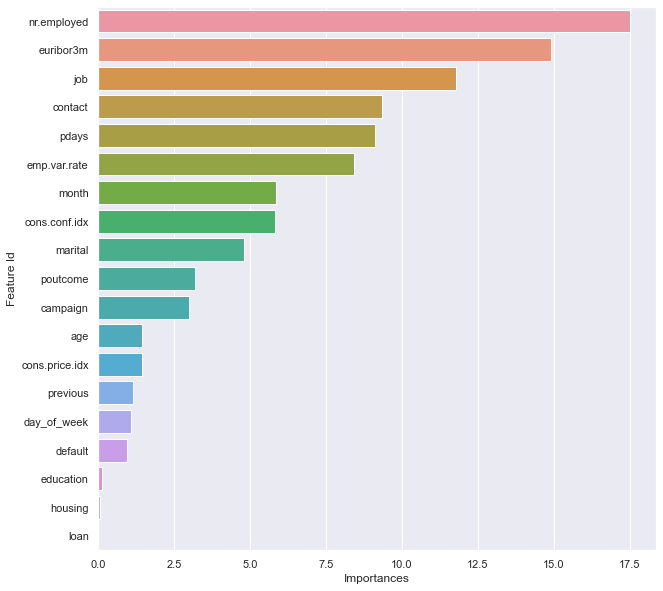

In [23]:
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.barplot(y='Feature Id', x = 'Importances', data = feature_importance.iloc[:20])
plt.show()

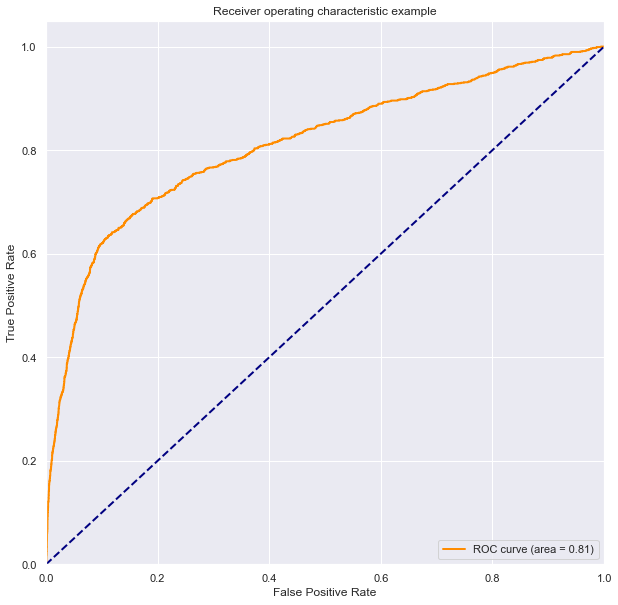

In [24]:
preds = model.predict(X_test,prediction_type = 'Probability')
predictions = preds[:,1].reshape(-1,1)
results = pd.DataFrame(data = np.hstack((y_test.values.reshape(-1,1), predictions)), columns = ['label', 'pred_proba'])

plotAUC(results.label, results.pred_proba)

# Results - discussion

Benchmark is from the paper "A Data-Driven Approach to Predict the Success of Bank Telemarketing" (https://doi.org/10.1016/j.dss.2014.03.001). Where a **benchmark AUC of 0.8** is reached.

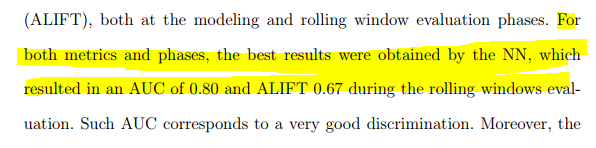

# Results - discussion

Benchmark is from the paper "A Data-Driven Approach to Predict the Success of Bank Telemarketing" (https://doi.org/10.1016/j.dss.2014.03.001). Where a **benchmark AUC of 0.8** is reached.

To not spent too much time on modelling, I will leave it at that. 

## Extra steps I would normally take
As this is "only" a take home exercise and not a regular project, I will only propose the extra steps I would usually take:
- Add some feature engineering! 
Currently there is no feature engineering and that is where a lot of performance can be found. Assuming that I work at the bank, a few things come to my mind:
    - Time series data of all transactions incoming and outgoing on the current account if available
    - Multibanking customer (has accounts @ a different bank) and aggregates on all multibank transactions
    - Salary, workplace, home address, distance of home address to home bank branch, weather at the moment of call (astonishingly that sometimes is not unimportant), general wealth of the home area, time since customer, telephone channel propensity (if available), sentiment score on last contacts with advisor, amount of logins into online banking... 
- Add different encoding techniques into a pipeline as a hyperparameter and tune the encodings 
- Try different models via an autoAI framework
- Keep track of training cost vs possible improvement
